<h2 style="text-align: center;">Generalized method of moments</h2>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize, curve_fit
from scipy.special import comb  # For binomial coefficients
import pandas as pd
from scipy.stats import qmc
from joblib import Parallel, delayed
import seaborn as sns



Let $(\Omega, \mathcal{F}, P)$ be a probability space. On this space, we define a standard Brownian motion $(W_t)_{t \geq 0}$ and its natural filtration $\mathcal{F} = (\mathcal{F}_t)_{t \geq 0}$. The Ornstein-Uhlenbeck process with parameters $(\kappa, \theta, \sigma)$ is the stochastic process solution to the following SDE:
$$
dX_t = \kappa (\theta - X_t) \, dt + \sigma \, dW_t, \quad X_0 = Y, \quad \mathcal{F}_0\text{-measurable}
$$
We use this simulate it : 
$$X_{t+h} = e^{-\kappa h} X_t + \theta \left( 1 - e^{-\kappa h} \right) + \sigma e^{-\kappa h} \int_{t}^{t+h} e^{-\kappa (t-s)} \, dW_s
$$
$$(Z[1], \dots, Z[n]) \sim \mathcal{N}(0, I_n)$$


$\text{For } k = 1, \dots, n \text{ do:}$
$$
\quad X[k] = e^{-\kappa h} X[k-1] + \theta \left( 1 - e^{-\kappa h} \right) + \sqrt{\frac{\sigma^2}{2\kappa}} \left( 1 - e^{-2\kappa h} \right) Z[k]$$
$$X_t \sim \mathcal{N} \left( e^{-\kappa t} X_0 + \theta (1 - e^{-\kappa t}), \frac{\sigma^2}{2\kappa} (1 - e^{-2\kappa t}) \right)$$
$$
X_{t+h} = e^{-\kappa h} X_t + \theta \left( 1 - e^{-\kappa h} \right)
+ \sigma e^{-\kappa h} \int_t^{t+h} e^{-\kappa (t-s)}\, dW_s.
$$

In [2]:
class Vasicek:
    def __init__(self, kappa, theta, sigma):
        """
        Initialize the parameters for the Vasicek model.
        
        :param kappa: Speed of mean reversion
        :param theta: Long-term mean level
        :param sigma: Volatility of the process
        """
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma

    def generate(self, X0, T, N, n):
        """
        Generate N trajectories of the Vasicek process on the interval [0, T] with a time step of T/n.
        
        :param X0: Initial value of the process
        :param T: The total time period
        :param N: Number of trajectories to generate
        :param n: Number of discretization steps (so time step is T/n)
        
        :return: Array of N trajectories discretized over the interval [0, T]
        """
        dt = T / n  # Adjusted time step for the interval [0, T]
        trajectories = np.zeros((N, n))  # Matrix to store the trajectories
        trajectories[:, 0] = X0  # Initialize all trajectories at X0

        for i in range(1, n):
            # Generate standard normal noise
            Z = np.random.randn(N)  # Standard normal random variables for each trajectory
            # Update the process value according to the Vasicek model
            trajectories[:, i] = (
                trajectories[:, i - 1] * np.exp(-self.kappa * dt)
                + self.theta * (1 - np.exp(-self.kappa * dt))
                +  np.sqrt((self.sigma**2) *(1 - np.exp(-2 * self.kappa * dt)) / (2 * self.kappa)) * Z
            )

        return trajectories


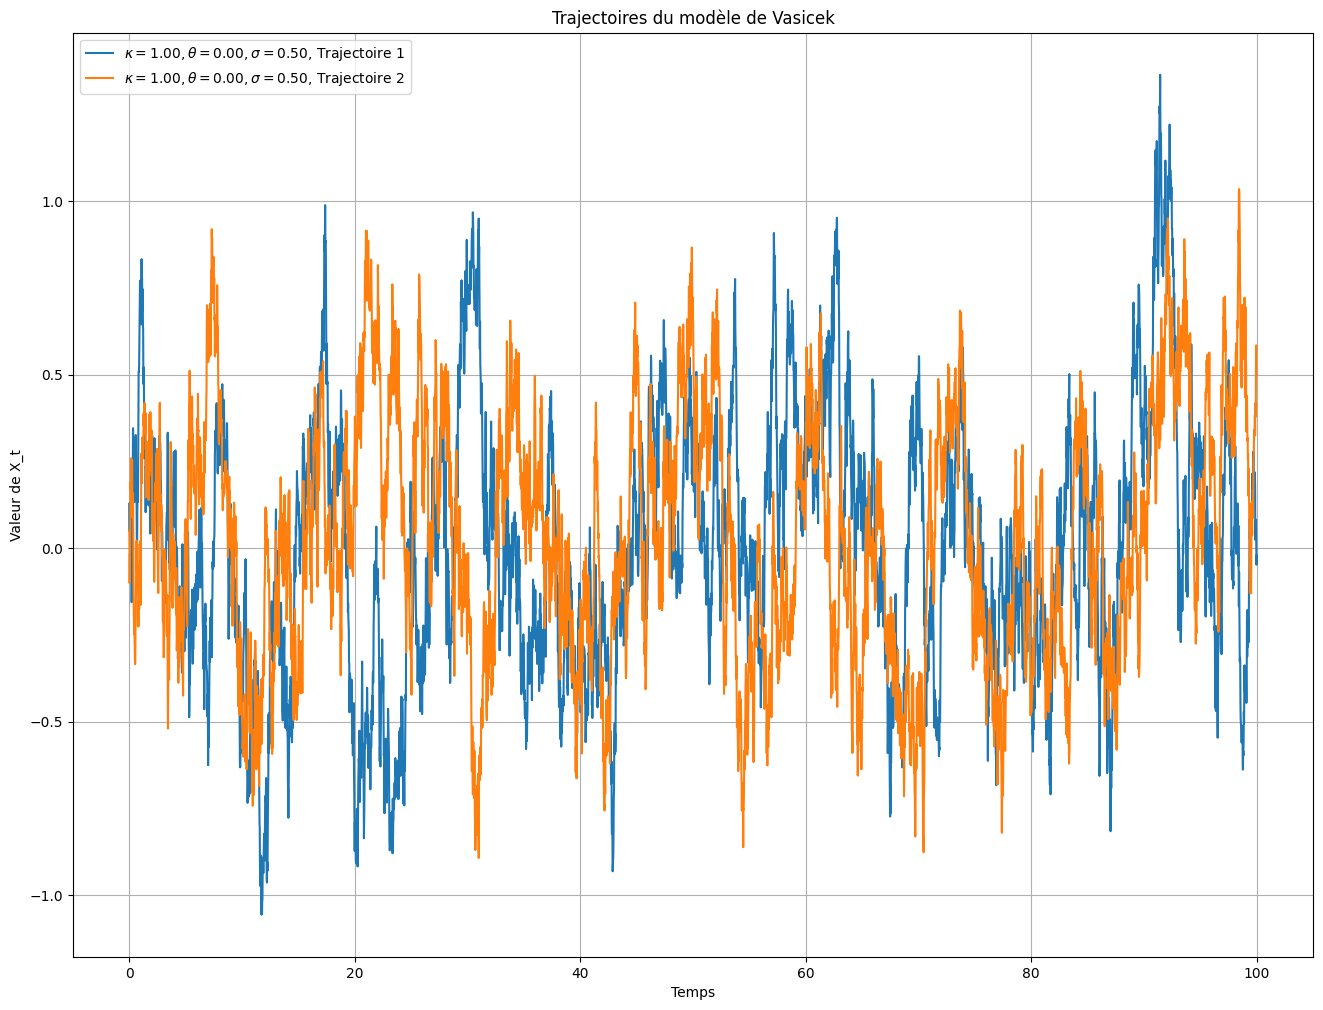

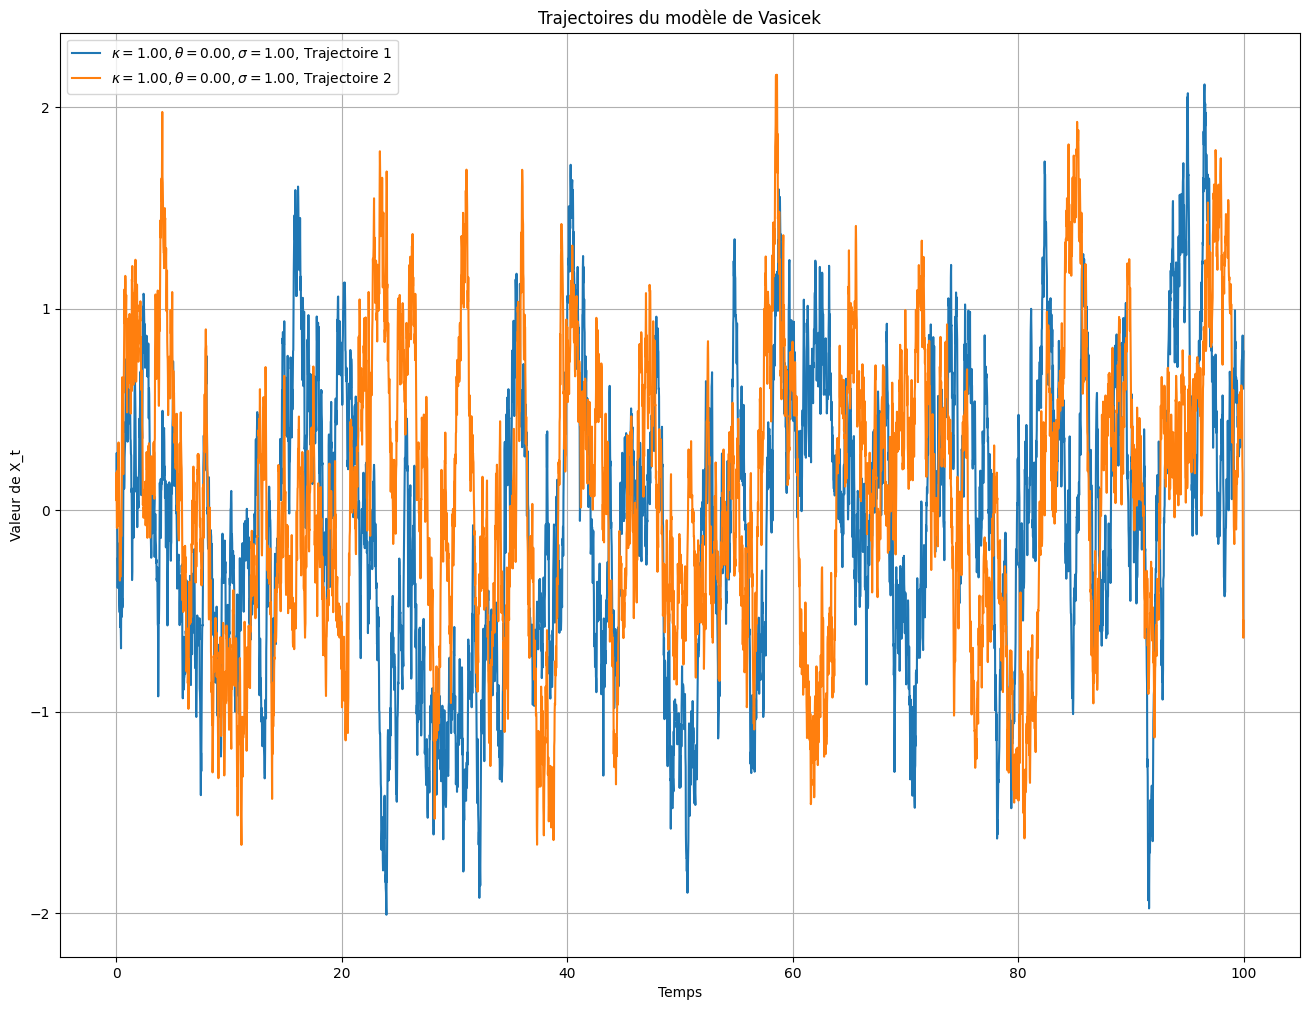

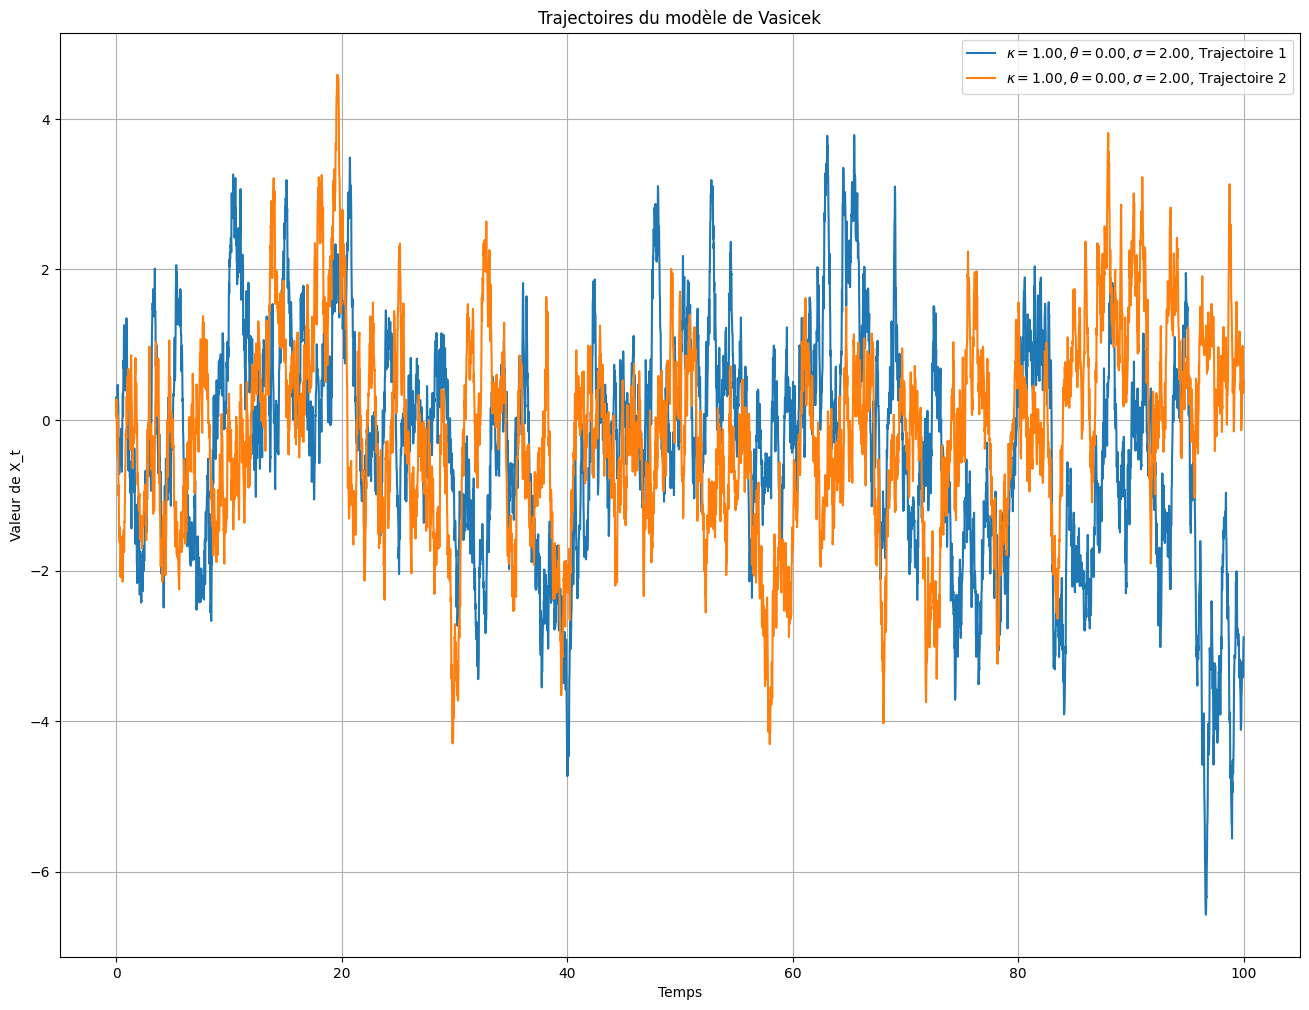

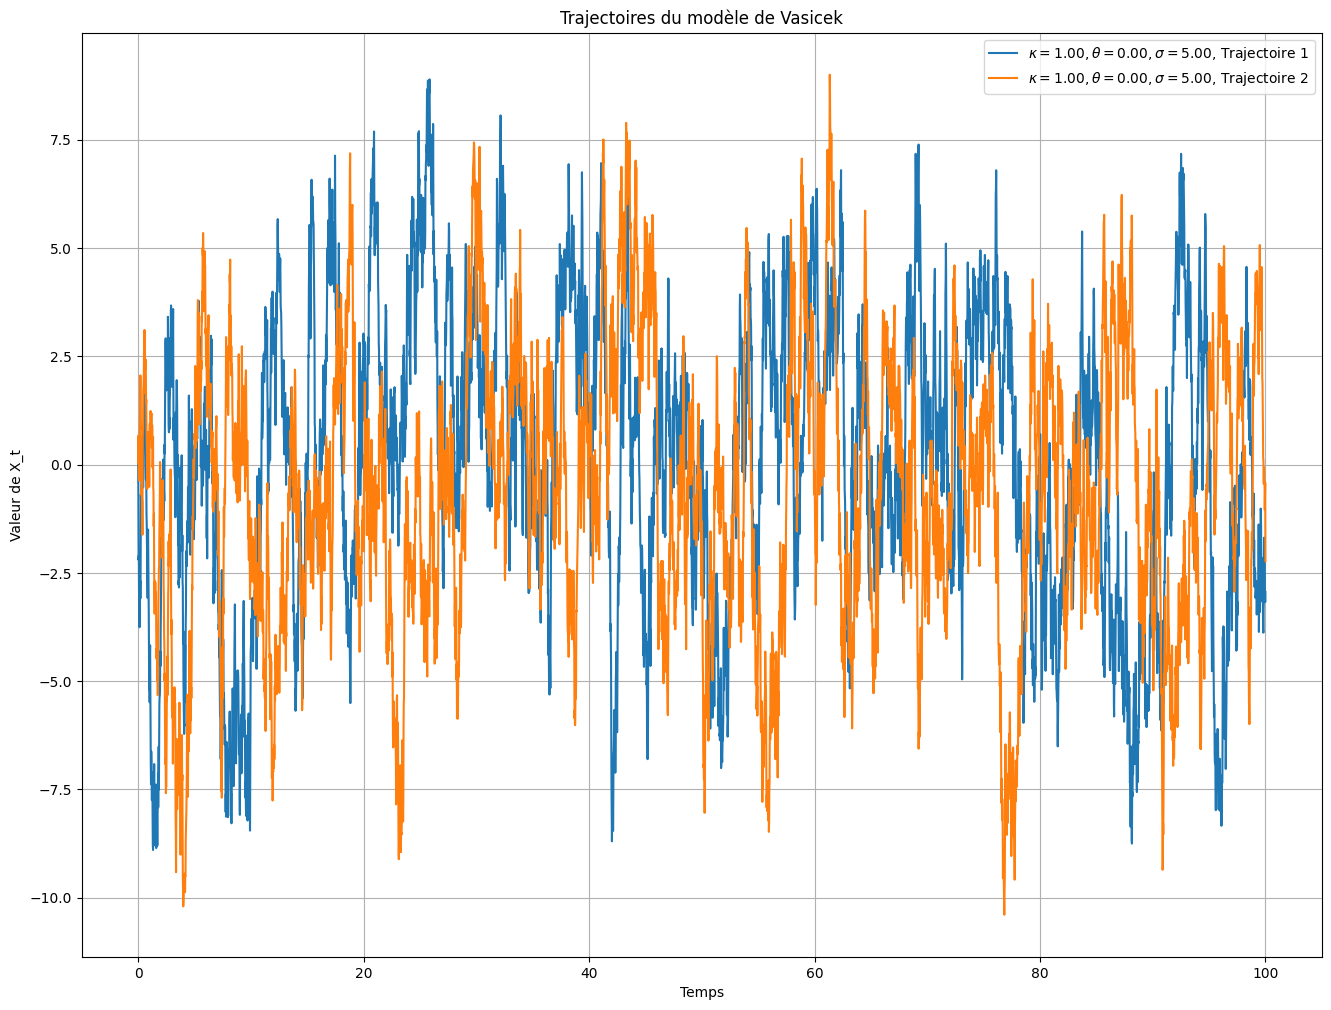

In [3]:
kappa = 1  
theta = 0  
X0 = 0.05  
N = 2  
n = 5000  
T = 100  

sigma_values = [0.5, 1, 2, 5]

for sigma in sigma_values:
    plt.figure(figsize=(16, 12))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    trajectories = vasicek_process.generate(X0, T, N, n)  
    
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"$\\kappa = {kappa:.2f}, \\theta = {theta:.2f}, \\sigma = {sigma:.2f}$, Trajectoire {i+1}")
    plt.title("Trajectoires du modèle de Vasicek")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()


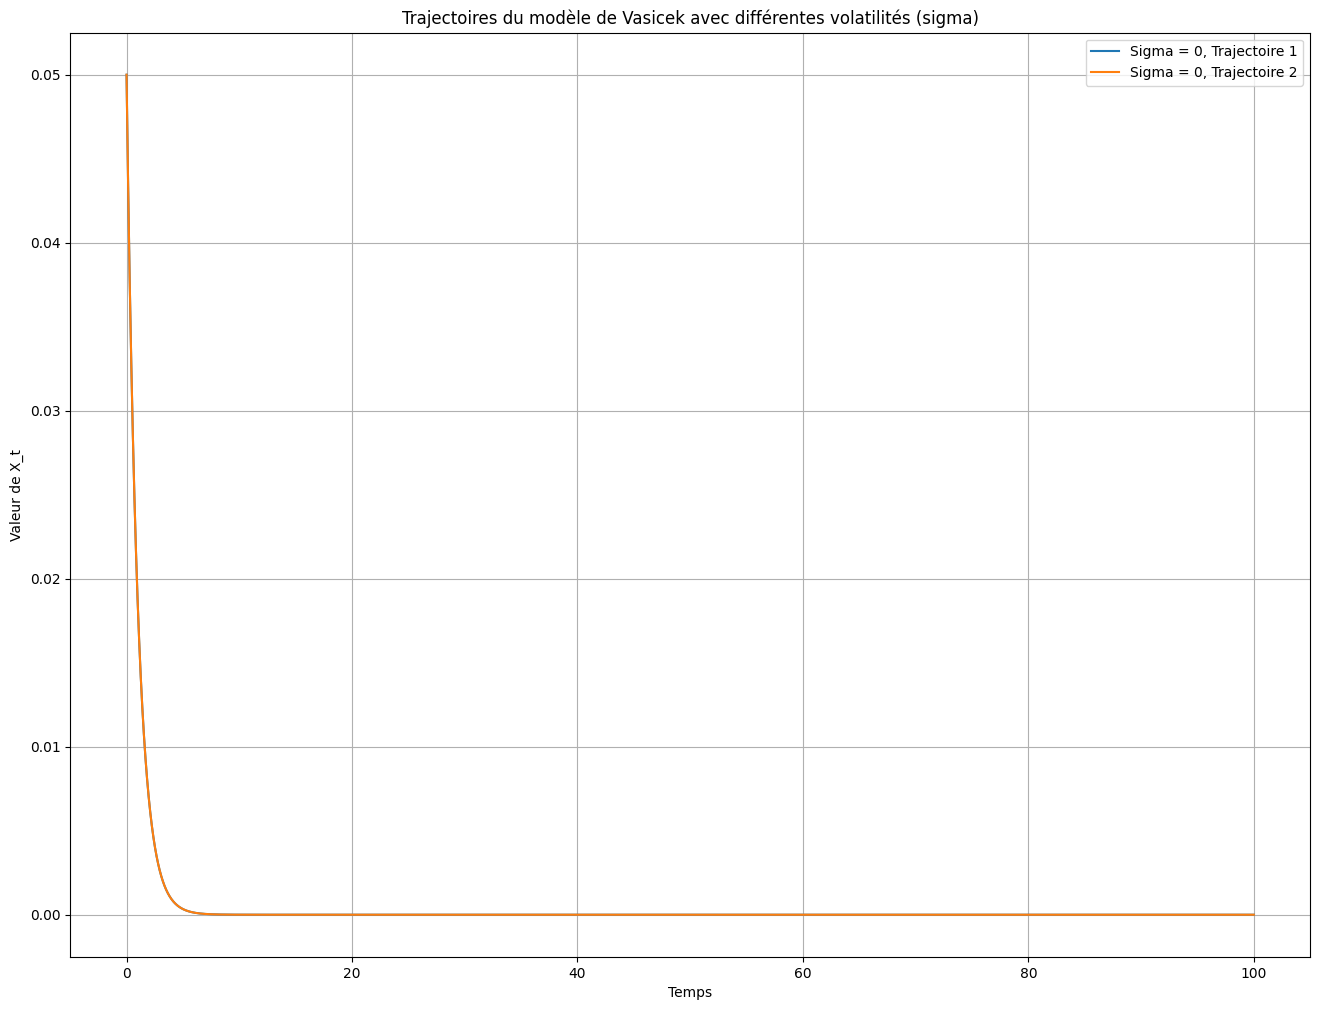

In [4]:
# Paramètres du modèle de Vasicek
kappa = 1  # vitesse de réversion vers la moyenne
theta = 0  # niveau de la moyenne à long terme
X0 = 0.05  # valeur initiale
N = 2  # nombre de trajectoires à générer
n = 5000  # nombre de pas de discrétisation    # Affichage des trajectoires générées pour chaque sigma

T = 100  # durée totale

# Liste des valeurs de sigma
sigma_values = [0]

# Créer un objet de la classe Vasicek et générer les trajectoires pour chaque valeur de sigma
for sigma in sigma_values:
    # Créer un objet avec la valeur de sigma courante
    plt.figure(figsize=(16, 12))
    vasicek_process = Vasicek(kappa, theta, sigma)
    
    # Générer les trajectoires
    trajectories = vasicek_process.generate(X0, T, N, n)  # Correction: Pass X0, T, N, n
    
    # Affichage des trajectoires générées pour chaque sigma
    time = np.linspace(0, T, n)
    for i in range(N):
        plt.plot(time, trajectories[i], label=f"Sigma = {sigma}, Trajectoire {i+1}")
    
    plt.title("Trajectoires du modèle de Vasicek avec différentes volatilités (sigma)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur de X_t")
    plt.legend()
    plt.grid(True)
    plt.show()

La fonction suivante calcule la quantité :
$$\frac{1}{n} \sum_{k=0}^n f(X_{t_k})$$
Il s'agit de la moyenne temporelle du processus sur les $n$ instants.

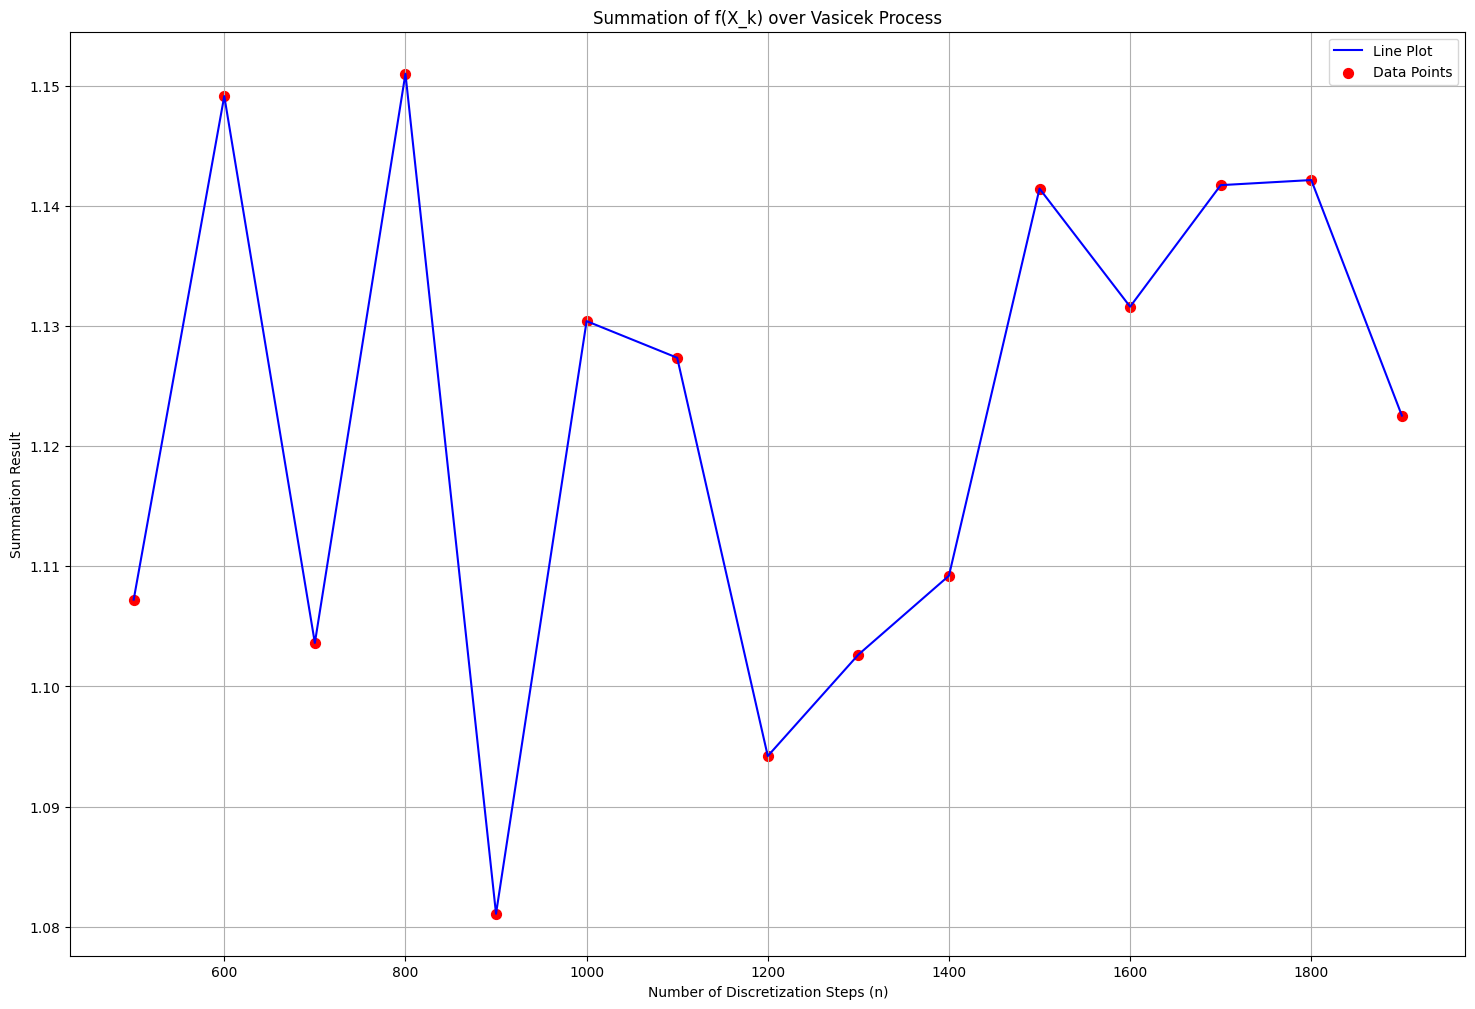

In [5]:
def calculate_sum(n, f, kappa=1, theta=1, sigma=0.5, X0=0.05,T=5000):
    """
    Calculate the summation: (1/n) * sum_{k=0}^n f(X_k), where X_k is generated by the Vasicek model.
    
    :param n: Number of steps in the discretization
    :param f: Function to apply to each X_k
    :param kappa: Speed of mean reversion
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param X0: Initial value of the process
    :return: The computed summation
    """
    vasicek_process = Vasicek(kappa, theta, sigma)
      # Time horizon

    # Generate one trajectory
    trajectories = vasicek_process.generate(X0, T, 1, n)  # One trajectory, n steps
    res = 0
    trajectory = trajectories[0]  # Take the first trajectory
    res +=(1 / n) * sum(f(x) for x in trajectory)
    # Compute the summation
    return res

# Define the function to apply to each X_k
f = lambda x: x**2  # Example: Square of each value

n_values = range(500, 2000, 100)  # Range of n values for testing
Y = [calculate_sum(n, f) for n in n_values]  # Compute the result for each n
# Plot the results
plt.figure(figsize=(18, 12))
plt.plot(n_values, Y, label="Line Plot", color="blue")  # Line plot
plt.scatter(n_values, Y, label="Data Points", color="red", s=50)  # Scatter plot
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process")
plt.grid(True)
plt.legend()  # Add a legend to differentiate the line and scatter plots
plt.show()

This function calculates this quantity :
$$\mathbb{E} (X_{\infty}^n)=\sum_{k=0}^n \binom{k}{n} \theta^{n-k} \frac{\sigma^k}{(2 \kappa)^{k/2}} \mathbb{E} (Z^k)$$
where $Z \sim \mathcal{N}(0,1)$

In [6]:
def expected_value_vasicek(power, theta, sigma, kappa):
    """
    Compute the expected value of the Vasicek process at X_n using the closed-form formula.
    
    :param n: Number of steps in the discretization
    :param theta: Long-term mean level
    :param sigma: Volatility
    :param kappa: Speed of mean reversion
    :return: The theoretical expected value
    """
    expected_sum = 0
    for k in range(power + 1):
        # Binomial coefficient
        binom_coeff = comb(power, k)
        
        # Factor for theta and sigma
        theta_factor = theta**(power - k)

        sigma_factor = sigma**k / (2 * kappa)**(k//2)
        
        # Expectation of Z^k
        if k % 2 == 0:  # Even powers of Z
            m = k // 2
            # For even k, the expectation of Z^{2m} is (2m-1)!! = (2m-1)*(2m-3)*...*1
            z_expectation = math.factorial(2 * m) // (2**m * math.factorial(m))  # Double factorial calculation
        else:  # Odd powers of Z
            z_expectation = 0
        
        # Add to the summation
        expected_sum += binom_coeff * theta_factor * sigma_factor * z_expectation
    
    return expected_sum

# True parameters
kappa_true = 5.89  # Vitesse de retour à la moyenne
theta_true = 1.55  # Moyenne long-terme
sigma_true = 2.38  # Volatilité
true_theta = 1.55
true_sigma = 2.38
true_kappa = 5.89
n = 2

# Compute theoretical expectation
true_value = expected_value_vasicek(n, theta, sigma, kappa)
print("Theoretical Expected Value:", true_value)


Theoretical Expected Value: 0.0


Theoretical Expected Value: 2.883348896434635
Average of computed Summation: 2.8808043144044406


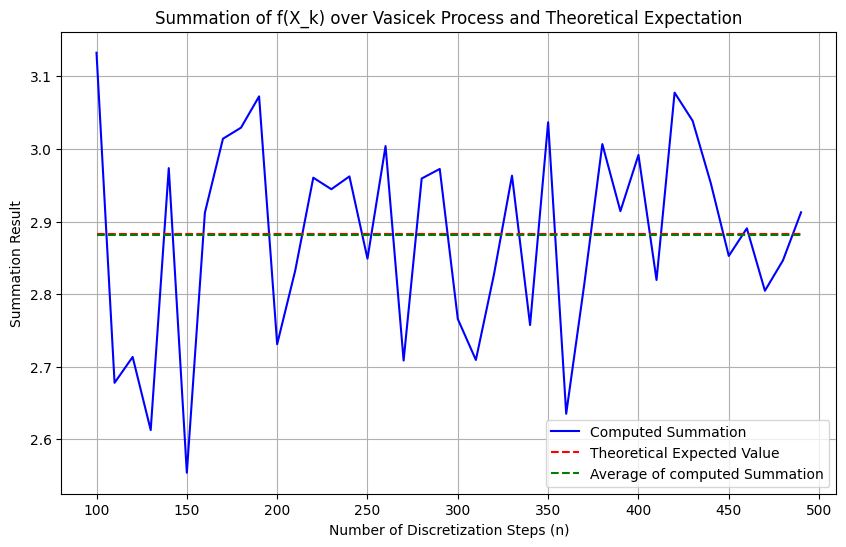

In [7]:
# Example parameters
kappa = 1  # Speed of mean reversion
theta = 1  # Long-term mean level
sigma = 0  # Volatility
X0 = 0.05  # Initial value
N = 1  # Only 1 trajectory for the summation computation
n_values = range(100, 500, 10)  # Range of n values for testing
n = 2 # Choose a large n for comparison

# Define the function to apply to each X_k
f = lambda x: x**n# Example: x^3

# Compute the summation for each value of n
Y = [calculate_sum(n, f, kappa=kappa_true, theta=theta_true, sigma=sigma_true, X0=X0) for n in n_values]
y0 = sum(Y)/len(Y)
# Compute the true value of the expectation
true_value = expected_value_vasicek(n, theta_true, sigma_true, kappa_true)
Y0 = [true_value for _ in n_values]  # Create a constant list for the theoretical expected value
Y1 = [y0 for _ in n_values]
# Print the theoretical expected value
print("Theoretical Expected Value:", true_value)
print("Average of computed Summation:", y0)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_values, Y, label="Computed Summation", color="blue")
plt.plot(n_values, Y0, label="Theoretical Expected Value", color="red", linestyle="--")
plt.plot(n_values, Y1, label="Average of computed Summation", color="green", linestyle="--")
plt.xlabel("Number of Discretization Steps (n)")
plt.ylabel("Summation Result")
plt.title("Summation of f(X_k) over Vasicek Process and Theoretical Expectation")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
#define params
n_simulations = 1000
n = 252*20
T = 20
X0 = 0.1
# True parameters
kappa_true = 0.589  # Vitesse de retour à la moyenne
theta_true = 0.155  # Moyenne long-terme
sigma_true = 0.238  # Volatilité
true_theta = 0.155
true_sigma = 0.238
true_kappa = 0.589
# Générer les données
vasicek_process = Vasicek(true_kappa, true_theta, true_sigma)
X = vasicek_process.generate(X0, T, n_simulations, n)  # X est de taille (n_simulations, n)
trajectories = np.copy(X)



# Estimation by "pure" moments

In [9]:
def empirical_value_vasicek(X, order):
    """Calcule la valeur empirique du moment d'ordre donné."""
    return np.mean(X**order)

def pure_moments_calibration(X, max_order, n_init=10):
    """Calibre les paramètres du modèle de Vasicek en minimisant l'erreur des moments purs."""

    # Moments empiriques
    orders = np.arange(1, max_order + 1)
    y_obs = np.array([empirical_value_vasicek(X, i) for i in orders])

    # Fonction coût vectorisée
    def cost(params):
        theta, sigma, kappa = params
        errors = np.array([expected_value_vasicek(i, theta, sigma, kappa) - y_obs[i-1] for i in orders])
        return np.sum(errors**2)

    # Initialisation
    sampler = qmc.LatinHypercube(d=3)
    initial_samples = qmc.scale(sampler.random(n_init), l_bounds=[0.01, 0.01, 0.01], u_bounds=[1, 1, 1])

    # Optimisation en parallèle
    def optimize_from_guess(guess):
        res = minimize(cost, guess, method='L-BFGS-B', bounds=[(1e-7, None), (1e-7, None), (1e-7, None)])
        return res.x, res.fun

    results = Parallel(n_jobs=-1)(delayed(optimize_from_guess)(guess) for guess in initial_samples)

    # Sélection de la meilleure solution
    best_params, best_cost = min(results, key=lambda x: x[1])

    return *best_params, best_cost


# Calibrer pour chaque ordre et chaque simulation
max_order = 6
n_values = range(3, max_order + 1,2)

# Structure des résultats
calibration_values = [[pure_moments_calibration(X[i], n) for n in n_values] for i in range(n_simulations)]


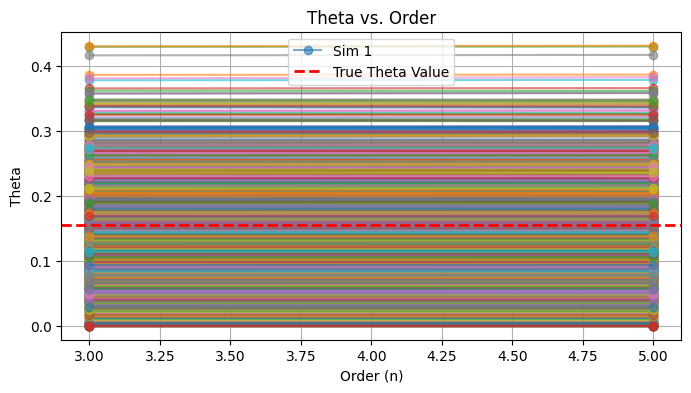

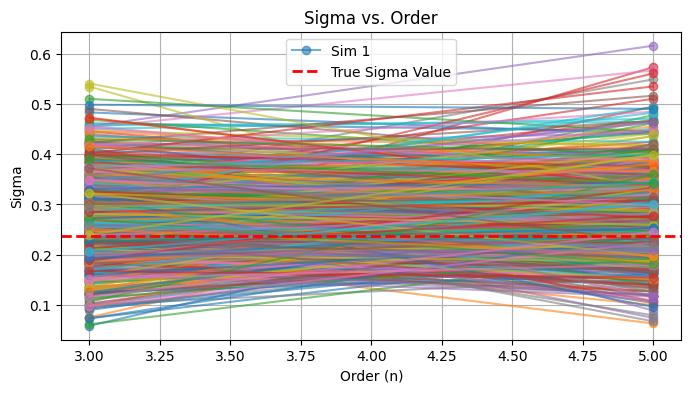

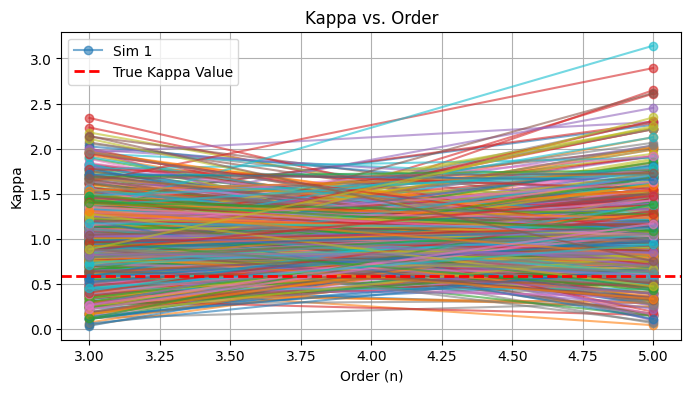

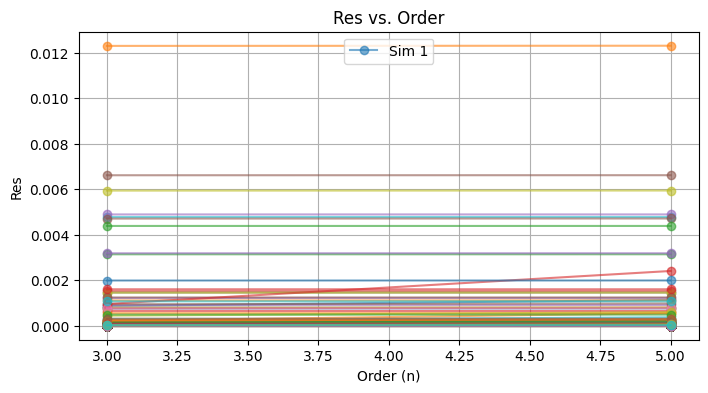

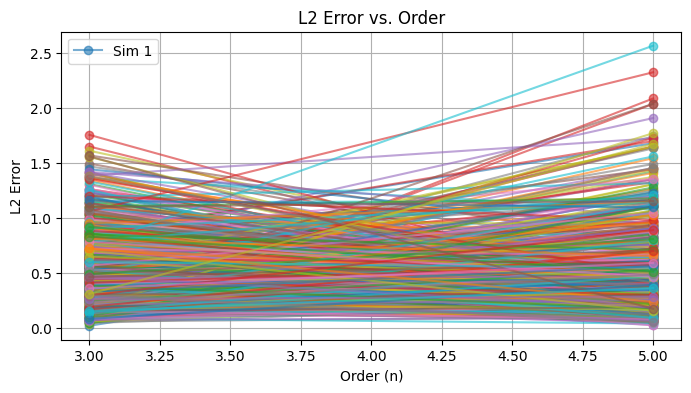

In [10]:
# Extraction des paramètres calibrés
theta_values = np.array([[params[0] for params in sim_values] for sim_values in calibration_values])
sigma_values = np.array([[params[1] for params in sim_values] for sim_values in calibration_values])
kappa_values = np.array([[params[2] for params in sim_values] for sim_values in calibration_values])
res_values = np.array([[params[3] for params in sim_values] for sim_values in calibration_values])

# Calcul du L2 error
l2_errors = np.sqrt(
    (theta_values - true_theta) ** 2 +
    (sigma_values - true_sigma) ** 2 +
    (kappa_values - true_kappa) ** 2
)

# Création d'un dictionnaire pour les paramètres
parameters = {
    'Theta': theta_values,
    'Sigma': sigma_values,
    'Kappa': kappa_values,
    'Res': res_values,
    'L2 Error': l2_errors
}

# Tracé des graphes
for param_name, param_values in parameters.items():
    plt.figure(figsize=(8, 4))

    # Tracer les courbes des 10 simulations
    for sim in range(n_simulations):
        plt.plot(n_values, param_values[sim], marker='o', linestyle='-', alpha=0.6, label=f'Sim {sim+1}' if sim == 0 else None)

    # Ajouter une ligne pour la vraie valeur (si applicable)
    if param_name in ['Theta', 'Sigma', 'Kappa']:
        plt.axhline(y={'Theta': true_theta, 'Sigma': true_sigma, 'Kappa': true_kappa}[param_name], 
                    color='red', linestyle='--', linewidth=2, label=f'True {param_name} Value')

    # Ajout des labels et du titre
    plt.xlabel('Order (n)')
    plt.ylabel(param_name)
    plt.title(f'{param_name} vs. Order')
    plt.legend()
    plt.grid(True)
    plt.show()


θ Estimate: Mean = 0.15081, Variance = 0.00698, True theta = 0.15500
σ Estimate: Mean = 0.27232, Variance = 0.00610, True sigma = 0.23800
κ Estimate: Mean = 1.03421, Variance = 0.15762, True kappa = 0.58900


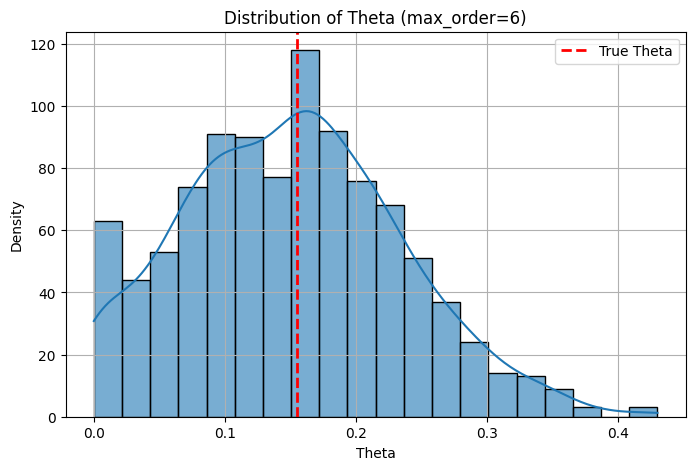

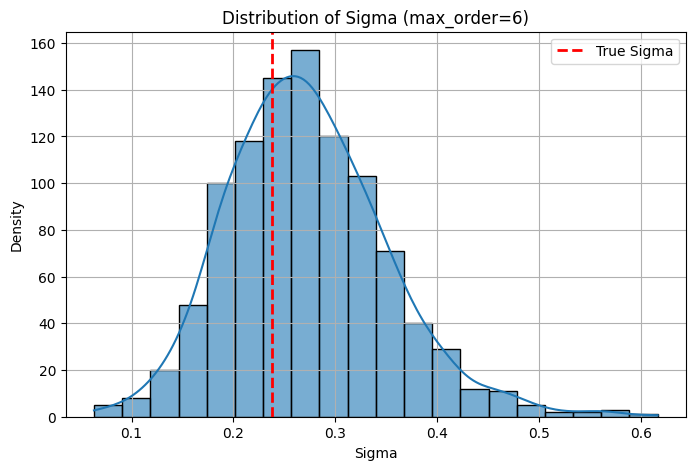

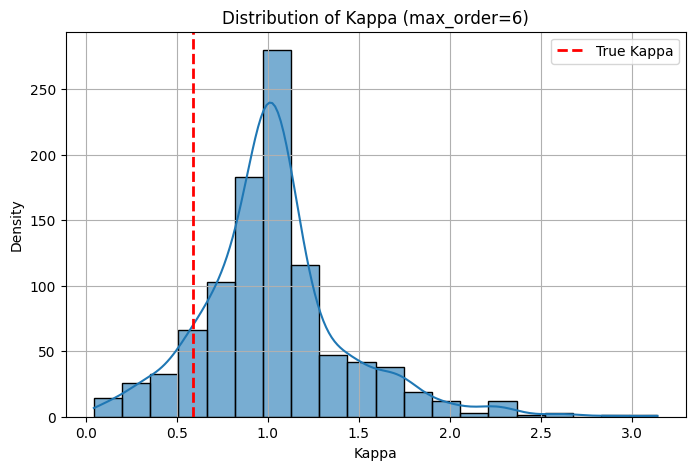

In [11]:

# Paramètres réels
true_values = {'Theta': true_theta, 'Sigma': true_sigma, 'Kappa': true_kappa}

# Extraction des valeurs pour max_order
theta_vals = [calibration_values[i][-1][0] for i in range(n_simulations)]
sigma_vals = [calibration_values[i][-1][1] for i in range(n_simulations)]
kappa_vals = [calibration_values[i][-1][2] for i in range(n_simulations)]
# Compute empirical mean and variance
theta_mean, theta_var = np.mean(theta_vals), np.var(theta_vals, ddof=1)
sigma_mean, sigma_var = np.mean(sigma_vals), np.var(sigma_vals, ddof=1)
kappa_mean, kappa_var = np.mean(kappa_vals), np.var(kappa_vals, ddof=1)

print(f"θ Estimate: Mean = {theta_mean:.5f}, Variance = {theta_var:.5f}, True theta = {true_theta:.5f}")
print(f"σ Estimate: Mean = {sigma_mean:.5f}, Variance = {sigma_var:.5f}, True sigma = {true_sigma:.5f}")
print(f"κ Estimate: Mean = {kappa_mean:.5f}, Variance = {kappa_var:.5f}, True kappa = {true_kappa:.5f}")  
# Structure des paramètres
params = {'Theta': theta_vals, 'Sigma': sigma_vals, 'Kappa': kappa_vals}

# Tracé des histogrammes avec KDE
for param_name, values in params.items():
    plt.figure(figsize=(8, 5))
    
    # Histogramme + KDE
    sns.histplot(values, bins=20, kde=True, edgecolor='black', alpha=0.6)
    
    # Ligne rouge pour la vraie valeur
    plt.axvline(true_values[param_name], color='red', linestyle='--', linewidth=2, label=f'True {param_name}')

    plt.xlabel(param_name)
    plt.ylabel('Density')
    plt.title(f'Distribution of {param_name} (max_order={max_order})')
    plt.legend()
    plt.grid(True)
    plt.show()

According to the paper provided by the tutor, incorporating a weight matrix enhances the estimation by improving its efficiency. The weight matrix allows the method to give more importance to the moments with lower variance, leading to a more accurate and robust parameter estimation.

## How the weight matrix is calculated

On the first step, GMM is performed with an arbitrary weighting matrix. We will use the identity here.  $\newline$
We will then these values to estimate the weight matrix $W.$
## Estimation with "pure" Moments with weight Matrix

/home/hassene/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hassene/.local/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


θ Estimate: Mean = 0.11455, Variance = nan, True theta = 0.15500
σ Estimate: Mean = 0.30839, Variance = nan, True sigma = 0.23800
κ Estimate: Mean = 1.36721, Variance = nan, True kappa = 0.58900
Number of values used for variance: 1000


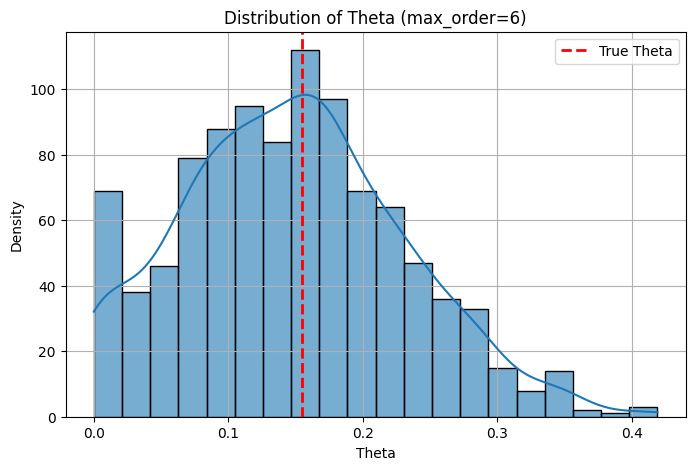

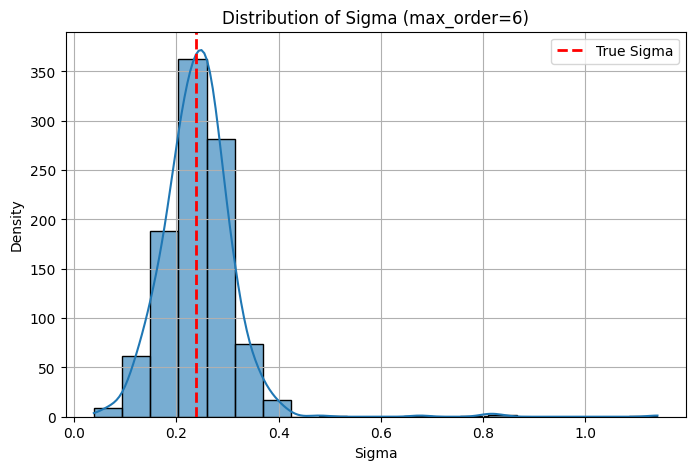

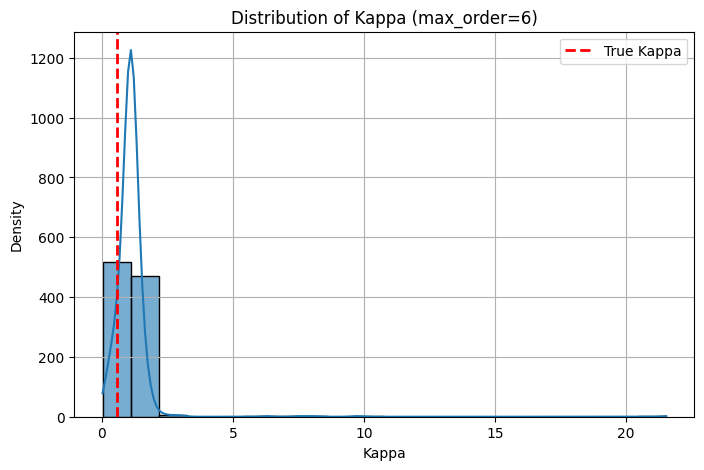

In [12]:

def empirical_moments(X, max_order):
    return np.array([np.mean(X**i) for i in range(1, max_order + 1)])

def compute_weight_matrix(X, theta, sigma, kappa, max_order):
    orders = np.arange(1, max_order + 1)
    n = X.shape[0]
    y_model = np.array([expected_value_vasicek(i, theta, sigma, kappa) for i in orders])
    errors = (X[:, None] ** orders[None, :]) - y_model
    S = np.cov(errors, rowvar=False)
    epsilon = 1e-6
    S += epsilon * np.eye(S.shape[0])
    W = np.linalg.inv(S)
    return W

def pure_moments_calibration_2step(X, max_order, n_init=10):
    """Calibration by Pure Moments using 2-Step GMM."""
    orders = np.arange(1, max_order + 1)
    y_obs = empirical_moments(X, max_order)
    W = np.eye(max_order)  # Initial weight matrix

    def cost(params):
        theta, sigma, kappa = params
        y_model = np.array([expected_value_vasicek(i, theta, sigma, kappa) for i in orders])
        errors = y_model - y_obs
        return errors @ W @ errors

    sampler = qmc.LatinHypercube(d=3)
    initial_samples = qmc.scale(sampler.random(n_init), l_bounds=[0.01, 0.01, 0.01], u_bounds=[1, 1, 1])

    def optimize_from_guess(guess, cost_fn):
        res = minimize(cost_fn, guess, method='L-BFGS-B', bounds=[(1e-7, None)] * 3)
        return res.x, res.fun

    # Step 1
    results = Parallel(n_jobs=-1)(delayed(optimize_from_guess)(guess, cost) for guess in initial_samples)
    best_params, _ = min(results, key=lambda x: x[1])
    theta_1, sigma_1, kappa_1 = best_params

    # Step 2: update weight matrix and re-minimize with new cost
    W = compute_weight_matrix(X, theta_1, sigma_1, kappa_1, max_order)

    def cost_step2(params):
        theta, sigma, kappa = params
        y_model = np.array([expected_value_vasicek(i, theta, sigma, kappa) for i in orders])
        errors = y_model - y_obs
        return errors @ W @ errors

    results2 = Parallel(n_jobs=-1)(delayed(optimize_from_guess)(guess, cost_step2) for guess in initial_samples)
    best_params2, best_cost = min(results2, key=lambda x: x[1])
    theta2, sigma2, kappa2 = best_params2

    return theta2, sigma2, kappa2, best_cost

max_order = 6
n_values = range(6, max_order + 1,2)

# Structure des résultats
calibration_values = [[pure_moments_calibration_2step(X[i], n) for n in n_values] for i in range(n_simulations)]
# Extraction des paramètres calibrés
theta_values = np.array([[params[0] for params in sim_values] for sim_values in calibration_values])
sigma_values = np.array([[params[1] for params in sim_values] for sim_values in calibration_values])
kappa_values = np.array([[params[2] for params in sim_values] for sim_values in calibration_values])
res_values = np.array([[params[3] for params in sim_values] for sim_values in calibration_values])


# Compute empirical mean and variance
theta_mean, theta_var = np.mean(theta_values[-1]), np.var(theta_values[-1], ddof=1)
sigma_mean, sigma_var = np.mean(sigma_values[-1]), np.var(sigma_values[-1], ddof=1)
kappa_mean, kappa_var = np.mean(kappa_values[-1]), np.var(kappa_values[-1], ddof=1)

print(f"θ Estimate: Mean = {theta_mean:.5f}, Variance = {theta_var:.5f}, True theta = {true_theta:.5f}")
print(f"σ Estimate: Mean = {sigma_mean:.5f}, Variance = {sigma_var:.5f}, True sigma = {true_sigma:.5f}")
print(f"κ Estimate: Mean = {kappa_mean:.5f}, Variance = {kappa_var:.5f}, True kappa = {true_kappa:.5f}")  
# Calcul du L2 error
l2_errors = np.sqrt(
    (theta_values - true_theta) ** 2 +
    (sigma_values - true_sigma) ** 2 +
    (kappa_values - true_kappa) ** 2
)

# Création d'un dictionnaire pour les paramètres
parameters = {
    'Theta': theta_values,
    'Sigma': sigma_values,
    'Kappa': kappa_values,
    'Res': res_values,
    'L2 Error': l2_errors
}
print("Number of values used for variance:", len(theta_values))


# Paramètres réels
true_values = {'Theta': true_theta, 'Sigma': true_sigma, 'Kappa': true_kappa}

# Extraction des valeurs pour max_order
theta_vals = [calibration_values[i][-1][0] for i in range(n_simulations)]
sigma_vals = [calibration_values[i][-1][1] for i in range(n_simulations)]
kappa_vals = [calibration_values[i][-1][2] for i in range(n_simulations)]

# Structure des paramètres
params = {'Theta': theta_vals, 'Sigma': sigma_vals, 'Kappa': kappa_vals}

# Tracé des histogrammes avec KDE
for param_name, values in params.items():
    plt.figure(figsize=(8, 5))
    
    # Histogramme + KDE
    sns.histplot(values, bins=20, kde=True, edgecolor='black', alpha=0.6)
    
    # Ligne rouge pour la vraie valeur
    plt.axvline(true_values[param_name], color='red', linestyle='--', linewidth=2, label=f'True {param_name}')

    plt.xlabel(param_name)
    plt.ylabel('Density')
    plt.title(f'Distribution of {param_name} (max_order={max_order})')
    plt.legend()
    plt.grid(True)
    plt.show()

## Estimation by First and Second-Order Moments

Here, I will present my theoretical results used for estimation in the Vasicek model.  
I used only the first two moments to estimate both $\sigma$ and $\kappa $. We will later see if we can improve this method.

$$
\bar{\theta} = \frac{1}{n} \sum_{i=1}^{n} X_i
$$

Let us define:

$$
X_0 = \bar{\theta}^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+1}
$$

$$
X_1 = \bar{\theta}^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+2}
$$

$$
h = \frac{T}{n}
$$
# Objective Function Minimization
The objective function is:
$$
L(\kappa, \sigma^2) = \left( \frac{\sigma^2}{2\kappa} e^{-\kappa h} - X_0 \right)^2 + \left( \frac{\sigma^2}{2\kappa} e^{-2\kappa h} - X_1 \right)^2 
$$



This is clearly achieved when :
$$\frac{\sigma^2}{2\kappa} e^{-\kappa h} - X_0  = 0 $$
and 
$$ \frac{\sigma^2}{2\kappa} e^{-2\kappa h} - X_1 =  0 $$

$$ e^{-\kappa h} = \frac{X_1}{X_0} $$
$$ \sigma ^2  = 2 \kappa  X_0 e^{\kappa h} = \frac{2 \kappa X_0^2}{X_1} $$


Finally, we have these results : 
$$\bar{\kappa} = \frac{1}{h} \ln( {\frac{(\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+1}}{(\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+2}}})$$
$\newline$

$$\bar {\sigma^2} = 2 \bar {\kappa} \frac{((\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+1})^2}{(\frac{1}{n} \sum_{i=1}^{n} X_i)^2 - \frac{1}{n} \sum_{i=1}^{n} X_i X_{i+2}}$$
$$\bar{\theta} = \frac{1}{n} \sum_{i=1}^{n} X_i$$

This is done with the normal moments method. We should of course extend this to the generalized method of moments and with lag terms.
An intersting property we have here is, 
$$
\left(\sigma e^{-\kappa(t_{k+1}-t_k)} \int_{t_k}^{t_{k+1}} e^{-\kappa(t-s)} \, dW_s\right)_k
$$
are i.i.d. with law :
$$
\mathcal{N}\!\left(0, \frac{\sigma^2}{2\kappa}\Bigl(1 - e^{-2\kappa h}\Bigr)\right),
$$
where $(h = t_{k+1} - t_k).$

$$
X_{t_j} \mid X_{t_i} \sim \mathcal{N}\!\left( e^{-\kappa (t_j-t_i)} X_{t_i} + \theta\Bigl(1 - e^{-\kappa (t_j-t_i)}\Bigr), \; \frac{\sigma^2}{2\kappa}\Bigl(1 - e^{-2\kappa (t_j-t_i)}\Bigr) \right).
$$

Here we do the implementation of the estimator of the vasicek model by using the forumlas found below for $\kappa,\sigma,\theta.$
$\newline$
These formulas were proved using the first and second lagging terms and the mean to estimate $\theta$.

I will add to that the estiamation using the first 3 pure moments after and inversing the functions.

I wil try after that to add a weight Matrix $W$ that will make the estimation way better.

According to the paper we have on GMM, we have this result we could apply into our model : 
Under some conditions we have : 
$$
\hat{\theta}_T \xrightarrow{p} \theta_0;

\newline

T^{1/2}(\hat{\theta}_T - \theta_0) \xrightarrow{d} N(0, V)
$$
where
$$

V = \left[ G(\theta_0)^T W G(\theta_0) \right]^{-1} G(\theta_0)^T W S(\theta_0) W G(\theta_0) \left[ G(\theta_0)^T W G(\theta_0) \right]^{-1}
\newline
$$

$$
\newline
S(\theta) = \lim_{T \to \infty} \operatorname{Var} \left[ T^{1/2} g_T (\theta) \right].
\newline
\hat {\theta}_T = (\hat{\kappa},\hat{\theta},\hat{\sigma ^2})
$$
$$ f(v_T,\theta) $$
is a q vector function where
 $$ \mathbb{E}(f(v_T,\theta))=0 $$
## Estimation with method of Moments

In [13]:

def moment_estimators(X, T):
    h = T / len(X)
    n = len(X) - 2  
    mean_X = np.mean(X)
    sum_X = np.sum(X[:-1]) / n
    sum_X_X1 = np.sum(X[:-1] * X[1:]) / n
    sum_X_X2 = np.sum(X[:-2] * X[2:]) / n
    
    numerator = (sum_X ** 2 - sum_X_X1)
    denominator = (sum_X ** 2 - sum_X_X2)
    
    kappa_hat = (1 / h) * np.log(numerator / denominator)
    sigma2_hat = -2 * kappa_hat * (numerator ** 2) / denominator  
    theta_hat = mean_X
    
    return theta_hat, sigma2_hat, kappa_hat

# Run simulations
theta_estimates, sigma_estimates, kappa_estimates = [], [], []
for i in range(n_simulations):
    
    theta_hat, sigma2_hat, kappa_hat = moment_estimators(X[i], T)
    theta_estimates.append(theta_hat)
    sigma_estimates.append(np.sqrt(sigma2_hat))  # Convert variance to standard deviation
    kappa_estimates.append(kappa_hat)

# Compute empirical mean and variance
theta_mean, theta_var = np.mean(theta_estimates), np.var(theta_estimates, ddof=1)
sigma_mean, sigma_var = np.mean(sigma_estimates), np.var(sigma_estimates, ddof=1)
kappa_mean, kappa_var = np.mean(kappa_estimates), np.var(kappa_estimates, ddof=1)

print(f"θ Estimate: Mean = {theta_mean:.5f}, Variance = {theta_var:.5f}, True theta = {true_theta:.5f}")
print(f"σ Estimate: Mean = {sigma_mean:.5f}, Variance = {sigma_var:.5f}, True sigma = {true_sigma:.5f}")
print(f"κ Estimate: Mean = {kappa_mean:.5f}, Variance = {kappa_var:.5f}, True kappa = {true_kappa:.5f}")  

θ Estimate: Mean = 0.14943, Variance = 0.00745, True theta = 0.15500
σ Estimate: Mean = 0.24657, Variance = 0.00011, True sigma = 0.23800
κ Estimate: Mean = 0.90672, Variance = 0.12660, True kappa = 0.58900


## Estimation with GMM using covariance terms

In [14]:
# Theoretical covariance function
def theoretical_covariance(h, kappa, sigma):
    return (sigma**2 / (2 * kappa)) * np.exp(-kappa * h)

# Empirical covariance function
def empirical_covariance(X, n, T, theta_emp, h):
    k0 = int(n * h / T)  # Convert lag h to index
    cov = 0
    for k in range(n - k0):
        cov += (X[k] * X[k + k0]) / (n - k0)
    return cov - theta_emp**2

# Function to estimate kappa and sigma using minimization
def estimate_kappa_sigma(X, n, T, theta_emp, lags):
    # Compute empirical covariance for the given lags
    covariances = np.array([empirical_covariance(X, n, T, theta_emp, h) for h in lags])

    # Loss function to minimize
    def loss(params):
        kappa, sigma = params
        return np.sum((covariances - theoretical_covariance(lags, kappa, sigma)) ** 2)

    # Use multiple random initializations
    def optimize_from_guess(guess):
        res = minimize(loss, guess, method='L-BFGS-B', bounds=[(1e-7, None), (1e-7, None)])
        return res.x, res.fun

    # Latin Hypercube Sampling for initial guesses
    sampler = qmc.LatinHypercube(d=2)
    n_init = 20
    initial_samples = qmc.scale(sampler.random(n_init), l_bounds=[0.01, 0.01], u_bounds=[1, 1])

    # Parallel optimization
    results = Parallel(n_jobs=-1)(delayed(optimize_from_guess)(guess) for guess in initial_samples)
    best_params, best_cost = min(results, key=lambda x: x[1])

    return best_params[0], best_params[1]


In [15]:
estimated_params = []
num_lags = 50
theta_estimates, sigma_estimates, kappa_estimates = [], [], []
lags = np.array([i * T / n for i in range(num_lags)])  # Define lags
for i in range(n_simulations):
    
    theta_emp = np.mean(X)  # Estimate theta as empirical mean
    kappa_hat, sigma_hat = estimate_kappa_sigma(X[i], n, T, theta_emp, lags)
    theta_estimates.append(theta_hat)
    sigma_estimates.append(np.sqrt(sigma2_hat))  # Convert variance to standard deviation
    kappa_estimates.append(kappa_hat)
    estimated_params.append((kappa_hat, theta_emp, sigma_hat))


# Compute empirical mean and variance
theta_mean, theta_var = np.mean(theta_estimates), np.var(theta_estimates, ddof=1)
sigma_mean, sigma_var = np.mean(sigma_estimates), np.var(sigma_estimates, ddof=1)
kappa_mean, kappa_var = np.mean(kappa_estimates), np.var(kappa_estimates, ddof=1)

print(f"θ Estimate: Mean = {theta_mean:.5f}, Variance = {theta_var:.5f}, True theta = {true_theta:.5f}")
print(f"σ Estimate: Mean = {sigma_mean:.5f}, Variance = {sigma_var:.5f}, True sigma = {true_sigma:.5f}")
print(f"κ Estimate: Mean = {kappa_mean:.5f}, Variance = {kappa_var:.5f}, True kappa = {true_kappa:.5f}")  

θ Estimate: Mean = 0.11358, Variance = 0.00000, True theta = 0.15500
σ Estimate: Mean = 0.25015, Variance = 0.00000, True sigma = 0.23800
κ Estimate: Mean = 1.15971, Variance = 2.60204, True kappa = 0.58900


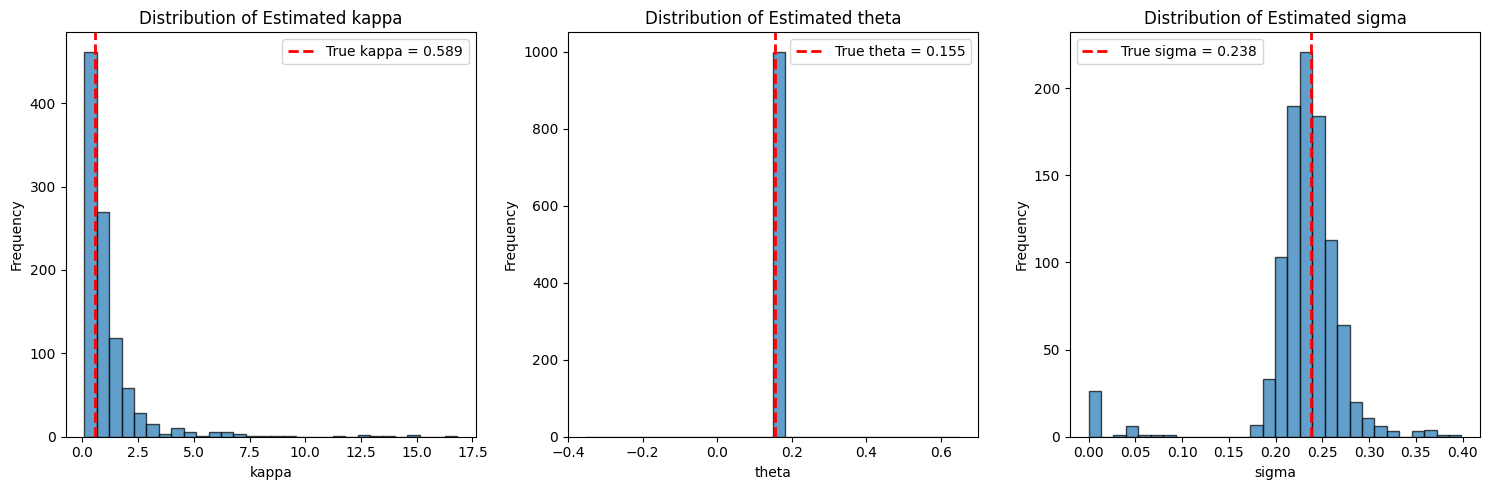

In [16]:
# Plot histograms
plt.figure(figsize=(15, 5))

estimated_params = np.array(estimated_params)  # conversion de la liste en array NumPy
# Histogram for kappa
plt.subplot(1, 3, 1)
plt.hist(estimated_params[:, 0], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(kappa_true, color='red', linestyle='dashed', linewidth=2, label=f'True kappa = {kappa_true}')
plt.xlabel('kappa')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated kappa')
plt.legend()

# Histogram for theta
plt.subplot(1, 3, 2)
plt.hist(estimated_params[:, 1], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(theta_true, color='red', linestyle='dashed', linewidth=2, label=f'True theta = {theta_true}')
plt.xlabel('theta')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated theta')
plt.legend()

# Histogram for sigma
plt.subplot(1, 3, 3)
plt.hist(estimated_params[:, 2], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(sigma_true, color='red', linestyle='dashed', linewidth=2, label=f'True sigma = {sigma_true}')
plt.xlabel('sigma')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated sigma')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

Empirical theta is: 0.22250358375654547
True theta is: 0.155
Number of Lags:  2
Number of Lags:  3
Number of Lags:  4
Number of Lags:  5
Number of Lags:  6
Number of Lags:  7
Number of Lags:  8
Number of Lags:  9
Number of Lags:  10
Number of Lags:  11
Number of Lags:  12
Number of Lags:  13
Number of Lags:  14
Number of Lags:  15
Number of Lags:  16
Number of Lags:  17
Number of Lags:  18
Number of Lags:  19
Number of Lags:  20
Number of Lags:  21
Number of Lags:  22
Number of Lags:  23
Number of Lags:  24


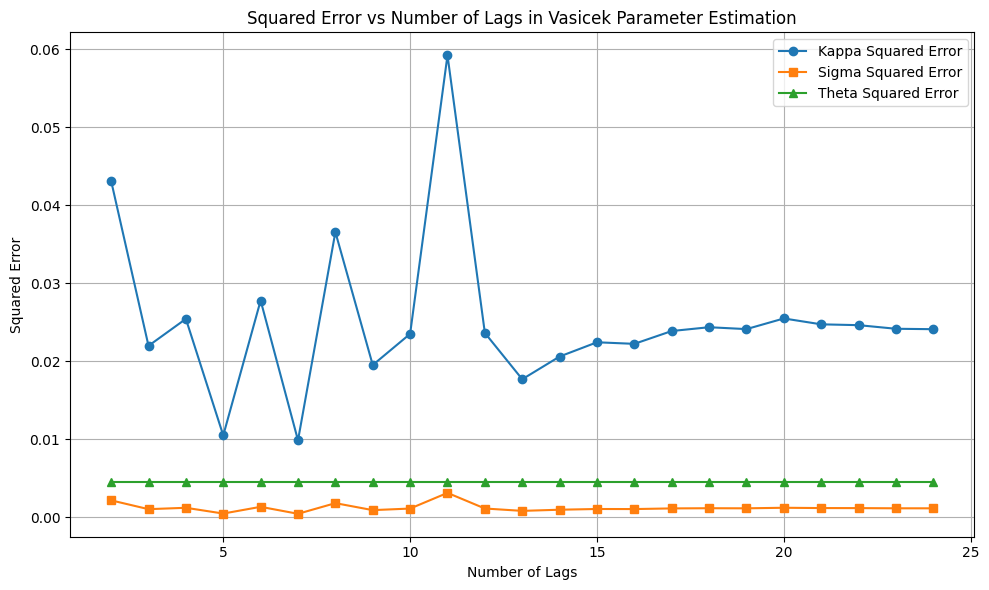

True kappa is: 0.589
True sigma is: 0.238
Estimated kappa is: 0.4337069979366337
Estimated sigma is: 0.20423789011437668


In [17]:
trajectory = X[0]
theta_emp = np.mean(trajectory)
print("Empirical theta is:", theta_emp)
print("True theta is:", theta_true)

# Range of lags
num_lags_list = np.arange(2, 25, 1)
kappa_sq_errors = []
sigma_sq_errors = []
theta_sq_errors = []

# Loop over different numbers of lags
for num_lags in num_lags_list:
    print("Number of Lags: ", num_lags)
    lags = np.array([i * T / n for i in range(num_lags)])
    
    kappa_est, sigma_est = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)
    
    # Squared errors
    kappa_sq_errors.append((kappa_est - kappa_true) ** 2)
    sigma_sq_errors.append((sigma_est - sigma_true) ** 2)
    theta_sq_errors.append((theta_emp - theta_true) ** 2)

# Plotting squared errors
plt.figure(figsize=(10, 6))
plt.plot(num_lags_list, kappa_sq_errors, label='Kappa Squared Error', marker='o')
plt.plot(num_lags_list, sigma_sq_errors, label='Sigma Squared Error', marker='s')
plt.plot(num_lags_list, theta_sq_errors, label='Theta Squared Error', marker='^')

plt.xlabel('Number of Lags')
plt.ylabel('Squared Error')
plt.title('Squared Error vs Number of Lags in Vasicek Parameter Estimation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print final estimates
print("True kappa is:", kappa_true)
print("True sigma is:", sigma_true)
print("Estimated kappa is:", kappa_est)
print("Estimated sigma is:", sigma_est)


# Estimation with GMM with covariance terms using Weight matirx

In [18]:
def covariance_2step(X, n, T, theta_emp, lags):
    empirical_covs = np.array([empirical_covariance(X, n, T, theta_emp, h) for h in lags])

    # === STEP 1: initial estimation via least squares ===
    def loss_step1(params):
        kappa, sigma = params
        model_covs = theoretical_covariance(lags, kappa, sigma)
        return np.sum((empirical_covs - model_covs) ** 2)

    bounds = [(1e-6, None), (1e-6, None)]

    # Latin Hypercube Sampling for step 1
    sampler = qmc.LatinHypercube(d=2)
    n_init = 10
    initial_samples = qmc.scale(
        sampler.random(n_init),
        l_bounds=[0.01, 0.01],
        u_bounds=[1.0, 1.0]
    )

    best_loss1 = float('inf')
    best_params1 = None

    for guess in initial_samples:
        res = minimize(loss_step1, guess, method='L-BFGS-B', bounds=bounds)
        if res.fun < best_loss1:
            best_loss1 = res.fun
            best_params1 = res.x

    kappa_init, sigma_init = best_params1

    # === STEP 2: optimal weighting (single estimation from step 1 result) ===
    theoretical_covs_init = theoretical_covariance(lags, kappa_init, sigma_init)
    residuals = empirical_covs - theoretical_covs_init

    S = np.outer(residuals, residuals)
    S += 1e-6 * np.eye(len(lags))  # Regularization
    try:
        W = np.linalg.inv(S)
    except np.linalg.LinAlgError:
        W = np.eye(len(lags))

    def loss_step2(params):
        kappa, sigma = params
        model_covs = theoretical_covariance(lags, kappa, sigma)
        diff = empirical_covs - model_covs
        return diff @ W @ diff

    res2 = minimize(loss_step2, best_params1, method='L-BFGS-B', bounds=bounds)
    kappa_final, sigma_final = res2.x

    return kappa_final, sigma_final


In [19]:
estimated_params = []
num_lags = 20
theta_estimates, sigma_estimates, kappa_estimates = [], [], []
lags = np.array([i * T / n for i in range(num_lags)])  # Define lags
for i in range(n_simulations//2):
    if (i%100==0):
        print(i)
    theta_emp = np.mean(X)  # Estimate theta as empirical mean
    kappa_hat, sigma_hat =covariance_2step(X[i], n, T, theta_emp, lags)
    theta_estimates.append(theta_hat)
    sigma_estimates.append(np.sqrt(sigma2_hat))  # Convert variance to standard deviation
    kappa_estimates.append(kappa_hat)
    estimated_params.append((kappa_hat, theta_emp, sigma_hat))


# Compute empirical mean and variance
theta_mean, theta_var = np.mean(theta_estimates), np.var(theta_estimates, ddof=1)
sigma_mean, sigma_var = np.mean(sigma_estimates), np.var(sigma_estimates, ddof=1)
kappa_mean, kappa_var = np.mean(kappa_estimates), np.var(kappa_estimates, ddof=1)

print(f"θ Estimate: Mean = {theta_mean:.5f}, Variance = {theta_var:.5f}, True theta = {true_theta:.5f}")
print(f"σ Estimate: Mean = {sigma_mean:.5f}, Variance = {sigma_var:.5f}, True sigma = {true_sigma:.5f}")
print(f"κ Estimate: Mean = {kappa_mean:.5f}, Variance = {kappa_var:.5f}, True kappa = {true_kappa:.5f}") 

0
100
200
300
400
θ Estimate: Mean = 0.11358, Variance = 0.00000, True theta = 0.15500
σ Estimate: Mean = 0.25015, Variance = 0.00000, True sigma = 0.23800
κ Estimate: Mean = 1.24054, Variance = 3.11241, True kappa = 0.58900


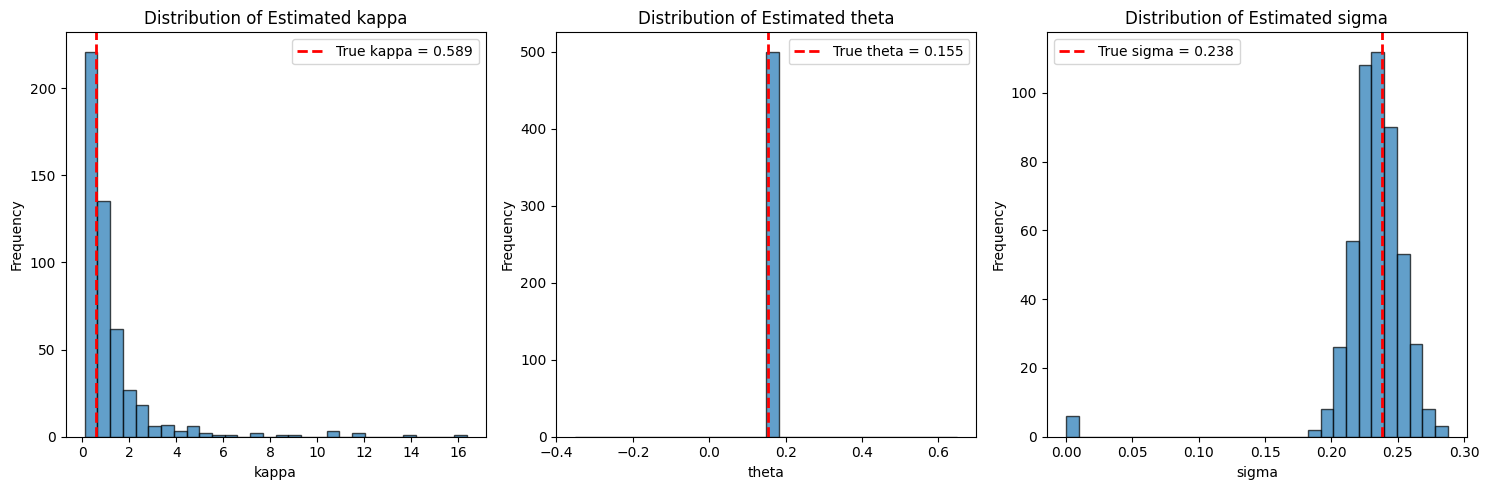

In [20]:

# Convert results to NumPy array
estimated_params = np.array(estimated_params)
# Plot histograms
plt.figure(figsize=(15, 5))

# Histogram for kappa
plt.subplot(1, 3, 1)
plt.hist(estimated_params[:, 0], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(kappa_true, color='red', linestyle='dashed', linewidth=2, label=f'True kappa = {kappa_true}')
plt.xlabel('kappa')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated kappa')
plt.legend()

# Histogram for theta
plt.subplot(1, 3, 2)
plt.hist(estimated_params[:, 1], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(theta_true, color='red', linestyle='dashed', linewidth=2, label=f'True theta = {theta_true}')
plt.xlabel('theta')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated theta')
plt.legend()

# Histogram for sigma
plt.subplot(1, 3, 3)
plt.hist(estimated_params[:, 2], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(sigma_true, color='red', linestyle='dashed', linewidth=2, label=f'True sigma = {sigma_true}')
plt.xlabel('sigma')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated sigma')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [21]:
for i in range(n_simulations):
   
    trajectory = X[i]

    # Compute empirical mean
    theta_emp = np.mean(trajectory)

    # Define the range of lags
    num_lags_list = np.arange(2, 12, 3)  
    kappa_errors = []
    sigma_errors = []

    # Loop over the number of lags
    for num_lags in num_lags_list:
        lags = np.array([i * T / n for i in range(num_lags)])  
        kappa_est, sigma_est = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)
        kappa_errors.append(np.abs(kappa_est - kappa_true))
        sigma_errors.append(np.abs(sigma_est - sigma_true))

    # Store last estimates (or take an average over all if you prefer)
    kappa_estimates.append(kappa_est)
    sigma_estimates.append(sigma_est)

# Compute empirical mean and variance of the estimates
kappa_mean = np.mean(kappa_estimates)
kappa_variance = np.var(kappa_estimates)
sigma_mean = np.mean(sigma_estimates)
sigma_variance = np.var(sigma_estimates)

# Print results
print("Empirical Mean of Estimated Kappa:", kappa_mean)
print("Empirical Variance of Estimated Kappa:", kappa_variance)
print("Empirical Mean of Estimated Sigma:", sigma_mean)
print("Empirical Variance of Estimated Sigma:", sigma_variance)


Empirical Mean of Estimated Kappa: 0.9591358293390774
Empirical Variance of Estimated Kappa: 1.1486737003449863
Empirical Mean of Estimated Sigma: 0.239040372423958
Empirical Variance of Estimated Sigma: 0.0002665995469877037


<h1>Maximum Likelihood Estimator (MLE)</h1>


In [22]:
def negative_log_likelihood(params):
    """
    Compute the log-likelihood for the Vasicek process given parameters.
    
    :param sigma: Volatility parameter (standard deviation)
    :param theta: Long-term mean level
    :param kappa: Speed of mean reversion
    :param n: Number of discretization steps
    :param T: Total time period (default is 1)
    
    :return: Log-likelihood value
    """
    # Create the Vasicek process model with given parameters
 # Take the first trajectory as the observed data
    sigma, theta, kappa = params

    dt = T / n  # Time step size

    # Initialize log-likelihood value
    log_likelihood_value = 0

    # First part of the log-likelihood
    term1 = -n / 2 * np.log(sigma**2 / (2 * kappa * (1 - np.exp(-2 * kappa * dt))))
    log_likelihood_value += term1
    # Third part: Sum of squared residuals
    residual_sum = 0
    for i in range(1, n):
        expected_value = trajectory[i - 1] * np.exp(-kappa * dt) + theta * (1 - np.exp(-kappa * dt))
        residual = trajectory[i] - expected_value
        residual_sum += residual**2
    
    # Fourth part: the sum over residuals
    term3 = -(kappa / (sigma**2 * (1 - np.exp(-2 * kappa * dt)))) * residual_sum
    log_likelihood_value += term3

    return -log_likelihood_value


In [23]:
trajectory = X[0]
def estimate_parameters_mle(trajectory = trajectory, T = T):
    n = len(trajectory)
    delta_t = T / n
    Rt = np.array(trajectory)
    
    # Calculate terms
    Rt_shifted = Rt[:-1]  # R_{t_{i-1}}
    Rt_current = Rt[1:]  # R_{t_i}
    
    #  (kappa)
    mean_RtRt_shifted = np.mean(Rt_current * Rt_shifted)
    mean_Rt = np.mean(Rt_current)
    mean_Rt_shifted = np.mean(Rt_shifted)
    mean_Rt_shifted_squared = np.mean(Rt_shifted ** 2)
    
    numerator_alpha = mean_RtRt_shifted - mean_Rt * mean_Rt_shifted
    denominator_alpha = mean_Rt_shifted_squared - mean_Rt_shifted ** 2
    kappa = -1 / delta_t * np.log(numerator_alpha / denominator_alpha)
    
    #  (theta)
    numerator_theta = np.sum(Rt_current) - np.exp(kappa * delta_t) * np.sum(Rt_shifted)
    denominator_theta = n * (1 - np.exp(-kappa * delta_t))
    theta = numerator_theta / denominator_theta
    
    # sigma^2
    term1 = Rt_current - Rt_shifted * np.exp(-kappa * delta_t)
    term2 = theta * (1 - np.exp(-kappa * delta_t))
    sigma_squared = (2 * kappa) / (n * (1 - np.exp(-2 * kappa * delta_t))) * np.sum((term1 - term2) ** 2)
    
    return kappa, abs(theta), np.sqrt(sigma_squared)
kappa, theta, sigma = estimate_parameters_mle()
print('kappa is ', kappa)
print('theta is ', abs(theta))
print('sigma is ', sigma)
print('true kappa is ', kappa_true)
print('true theta is ',abs( theta_true))
print('true sigma is', sigma_true)


kappa is  0.5624013068600094
theta is  0.22077968631991968
sigma is  0.232539107571754
true kappa is  0.589
true theta is  0.155
true sigma is 0.238


## Comparison of MLE and GMM

Here we compare both the MLE and GMM

In [24]:
def MSE(params,true_params):
    return np.mean((params - true_params) ** 2)

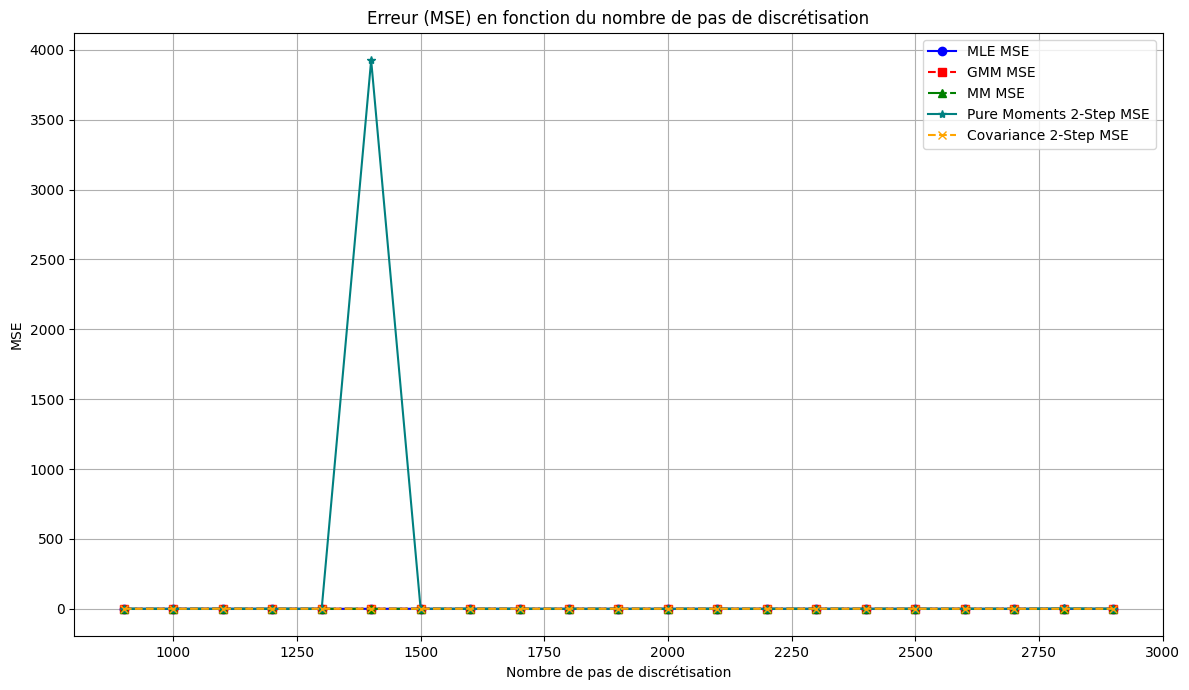

In [25]:
def process_trajectory(trajectory, n, T, kappa_true, theta_true, sigma_true, max_order, num_lags):
    theta_emp = np.mean(trajectory)
    lags = np.array([i * T / n for i in range(num_lags)])

    # MLE
    kappa_MLE, theta_MLE, sigma_MLE = estimate_parameters_mle(trajectory, T)
    mse_MLE = MSE(np.array([kappa_MLE, theta_MLE, sigma_MLE]), np.array([kappa_true, theta_true, sigma_true]))

    # GMM (cov simple)
    kappa_GMM, sigma_GMM = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)
    mse_GMM = MSE(np.array([kappa_GMM, theta_emp, sigma_GMM]), np.array([kappa_true, theta_true, sigma_true]))

    # MM (moment formulas)
    theta_MM, sigma2_MM, kappa_MM = moment_estimators(trajectory, T)
    mse_MM = MSE(np.array([kappa_MM, theta_MM, sigma2_MM]), np.array([kappa_true, theta_true, sigma_true]))

    # Pure Moments 1-Step
    theta_PM1, sigma2_PM1, kappa_PM1, _ = pure_moments_calibration(trajectory, max_order)
    mse_PM1 = MSE(np.array([kappa_PM1, theta_PM1, sigma2_PM1]), np.array([kappa_true, theta_true, sigma_true]))

    # Pure Moments 2-Step
    theta_PM2, sigma2_PM2, kappa_PM2, _ = pure_moments_calibration_2step(trajectory, max_order)
    mse_PM2 = MSE(np.array([kappa_PM2, theta_PM2, sigma2_PM2]), np.array([kappa_true, theta_true, sigma_true]))

    # Covariance 2-Step
    kappa_COV2, sigma_COV2 = covariance_2step(trajectory, n, T, theta_emp, lags)
    mse_COV2 = MSE(np.array([kappa_COV2, theta_emp, sigma_COV2]), np.array([kappa_true, theta_true, sigma_true]))

    return mse_MLE, mse_GMM, mse_MM, mse_PM1, mse_PM2, mse_COV2

def plot_errors(n_range, MLE_error, GMM_error, MM_error, pure_MM_error, pure_2_MM_error, cov_2_MM_error):
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(n_range, MLE_error, label='MLE MSE', marker='o', color='b')
    ax.plot(n_range, GMM_error, label='GMM MSE', marker='s', linestyle='dashed', color='r')
    ax.plot(n_range, MM_error, label='MM MSE', marker='^', linestyle='-.', color='g')
    #ax.plot(n_range, pure_MM_error, label='Pure Moments 1-Step MSE', marker='d', linestyle=':', color='purple')
    ax.plot(n_range, pure_2_MM_error, label='Pure Moments 2-Step MSE', marker='*', linestyle='-', color='teal')
    ax.plot(n_range, cov_2_MM_error, label='Covariance 2-Step MSE', marker='x', linestyle='--', color='orange')

    ax.set_xlabel('Nombre de pas de discrétisation')
    ax.set_ylabel('MSE')
    ax.set_title('Erreur (MSE) en fonction du nombre de pas de discrétisation')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


# ========= Code Principal ==========

n_range = range(900, 3000, 100)

N = 1
X0 = 0.05


MLE_error = []
GMM_error = []
MM_error = []
pure_MM_error = []
pure_2_MM_error = []
cov_2_MM_error = []
T = 20
n= 252*20
num_lags = 10
max_order = 10

for n in n_range:
    vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
    trajectory = vasicek_process.generate(X0, T, N, n)[0]

    mse_MLE, mse_GMM, mse_MM, mse_PM1, mse_PM2, mse_COV2 = process_trajectory(
        trajectory, n, T, kappa_true, theta_true, sigma_true, max_order, num_lags
    )

    MLE_error.append(mse_MLE)
    GMM_error.append(mse_GMM)
    MM_error.append(mse_MM)
    pure_MM_error.append(mse_PM1)
    pure_2_MM_error.append(mse_PM2)
    cov_2_MM_error.append(mse_COV2)

# === Plot final ===
plot_errors(n_range, MLE_error, GMM_error, MM_error, pure_MM_error, pure_2_MM_error, cov_2_MM_error)


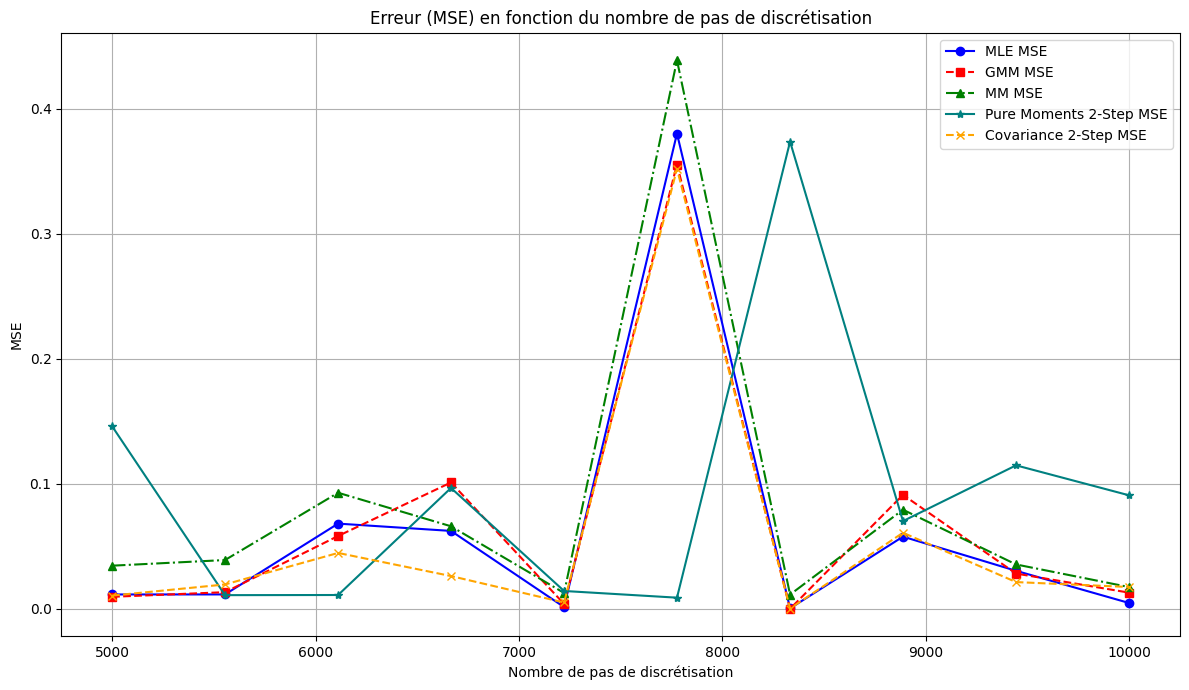

In [26]:
n_range = np.linspace(250*20, 500*20, 10, dtype=int)  # 5 valeurs entre 250 et 1000

N = 100
T = 20
X0 = 0.05

MLE_error = []
GMM_error = []
MM_error = []
pure_MM_error = []
pure_2_MM_error = []
cov_2_MM_error = []

num_lags = 10
max_order = 6

for n in n_range:
    vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
    trajectory = vasicek_process.generate(X0, T, N, n)[0]

    mse_MLE, mse_GMM, mse_MM, mse_PM1, mse_PM2, mse_COV2 = process_trajectory(
        trajectory, n, T, kappa_true, theta_true, sigma_true, max_order, num_lags
    )

    MLE_error.append(mse_MLE)
    GMM_error.append(mse_GMM)
    MM_error.append(mse_MM)
    pure_MM_error.append(mse_PM1)
    pure_2_MM_error.append(mse_PM2)
    cov_2_MM_error.append(mse_COV2)

# === Plot final ===
plot_errors(n_range, MLE_error, GMM_error, MM_error, pure_MM_error, pure_2_MM_error, cov_2_MM_error)


/tmp/ipykernel_603738/310495951.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


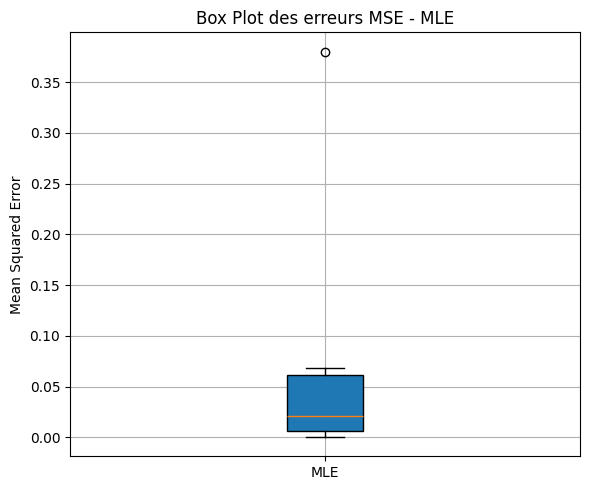

/tmp/ipykernel_603738/310495951.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


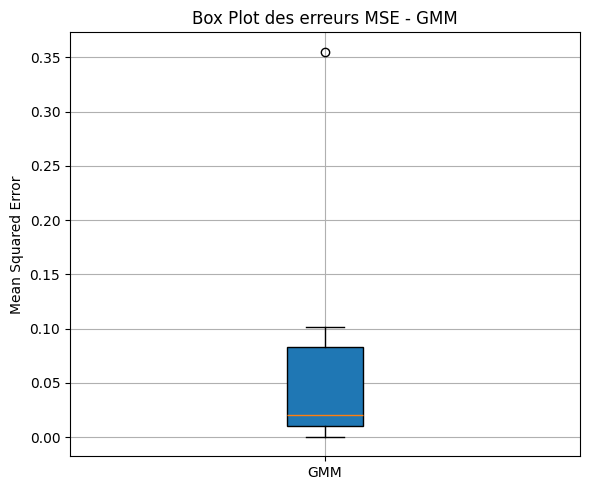

/tmp/ipykernel_603738/310495951.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


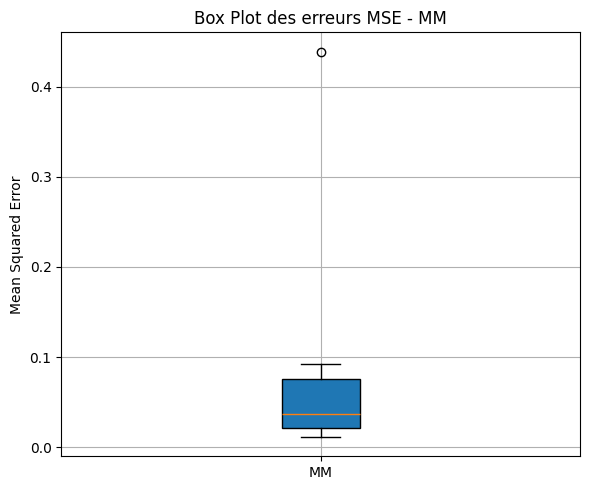

/tmp/ipykernel_603738/310495951.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


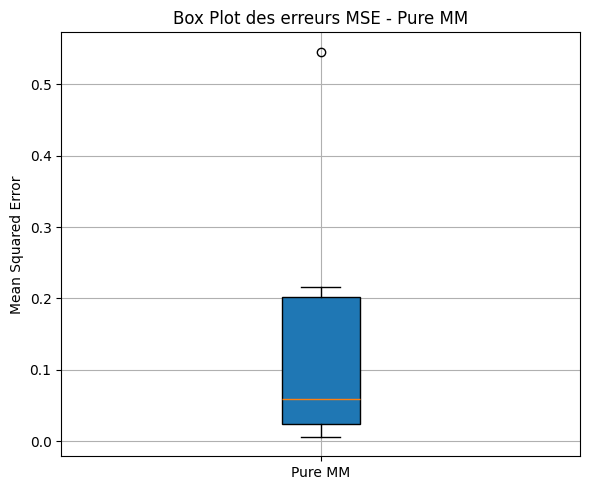

/tmp/ipykernel_603738/310495951.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


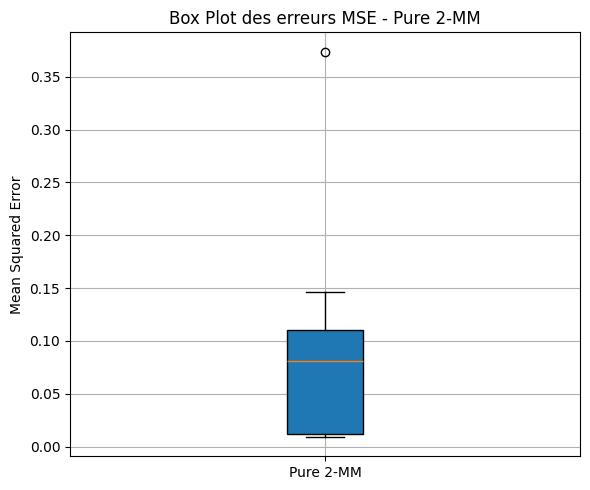

/tmp/ipykernel_603738/310495951.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([error], labels=[label], patch_artist=True)


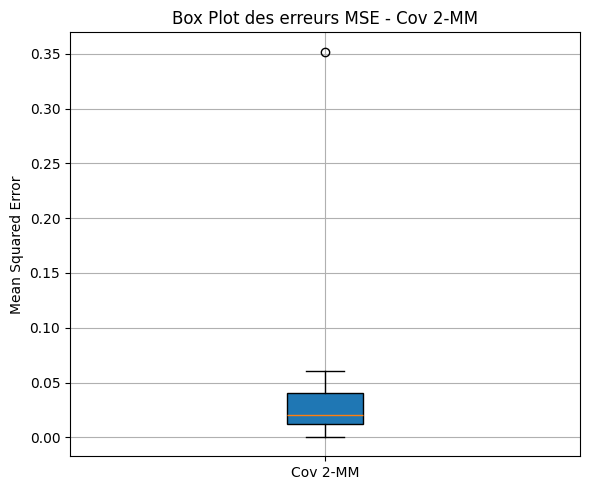

In [27]:

# Assure que les erreurs sont bien des vecteurs 1D
MLE_error = np.array(MLE_error).flatten()
GMM_error = np.array(GMM_error).flatten()
MM_error = np.array(MM_error).flatten()
pure_MM_error = np.array(pure_MM_error).flatten()
pure_2_MM_error = np.array(pure_2_MM_error).flatten()
cov_2_MM_error = np.array(cov_2_MM_error).flatten()

# Toutes les erreurs et leurs étiquettes
all_errors = [
    MLE_error,
    GMM_error,
    MM_error,
    pure_MM_error,
    pure_2_MM_error,
    cov_2_MM_error
]

labels = ["MLE", "GMM", "MM", "Pure MM", "Pure 2-MM", "Cov 2-MM"]

# Afficher un box plot par méthode
for error, label in zip(all_errors, labels):
    plt.figure(figsize=(6, 5))
    plt.boxplot([error], labels=[label], patch_artist=True)
    plt.title(f"Box Plot des erreurs MSE - {label}")
    plt.ylabel("Mean Squared Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


3


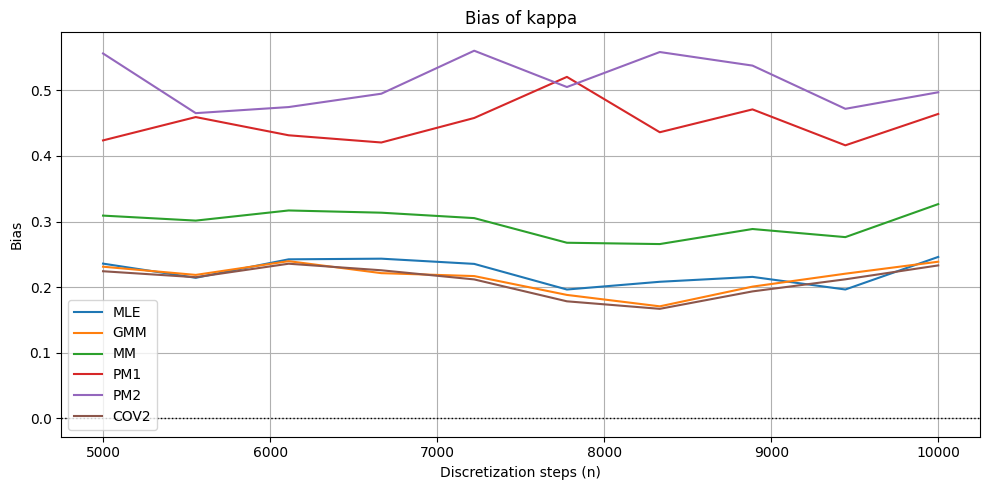

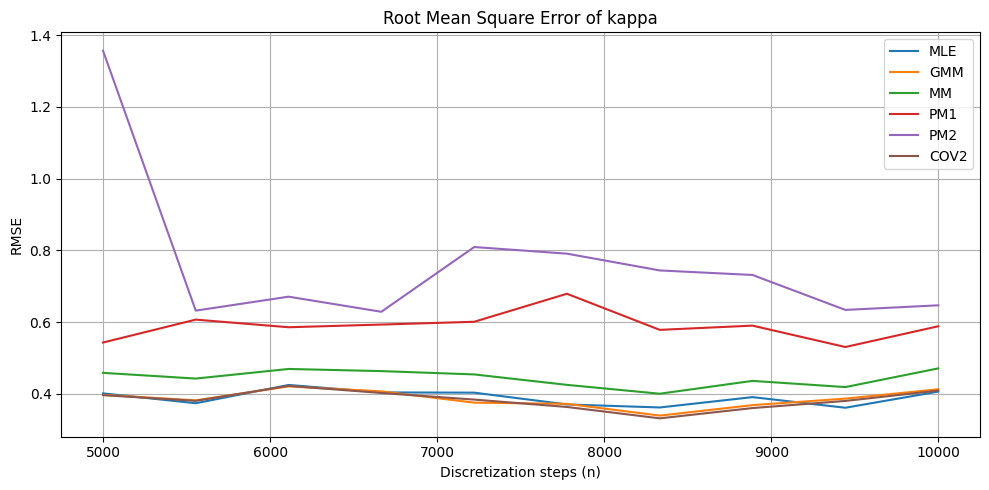

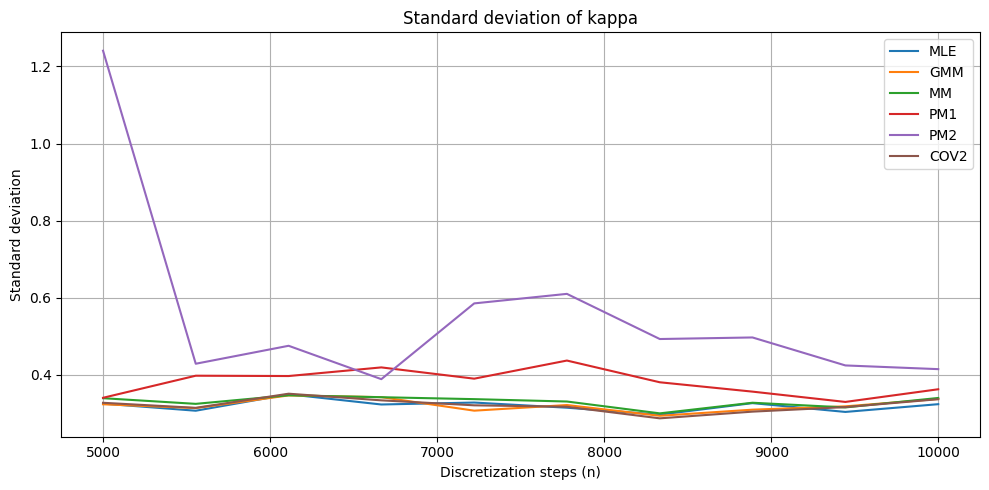

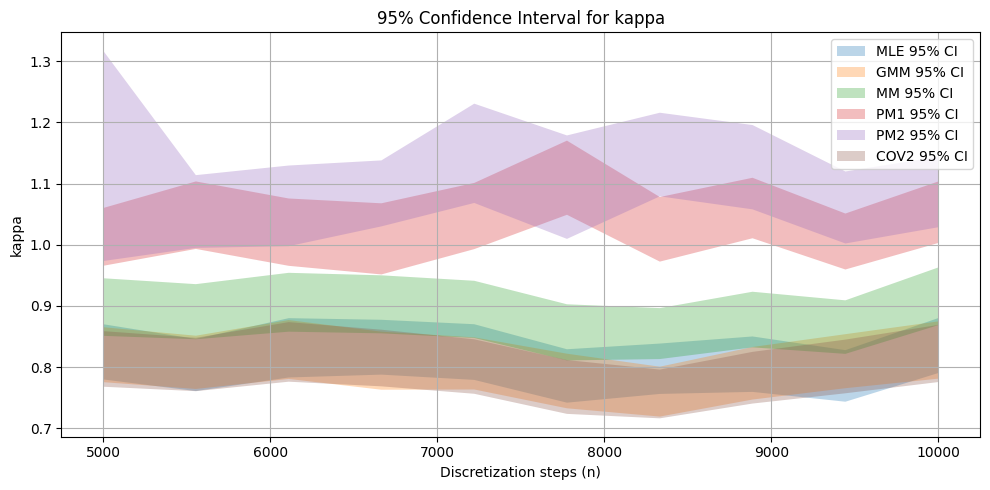

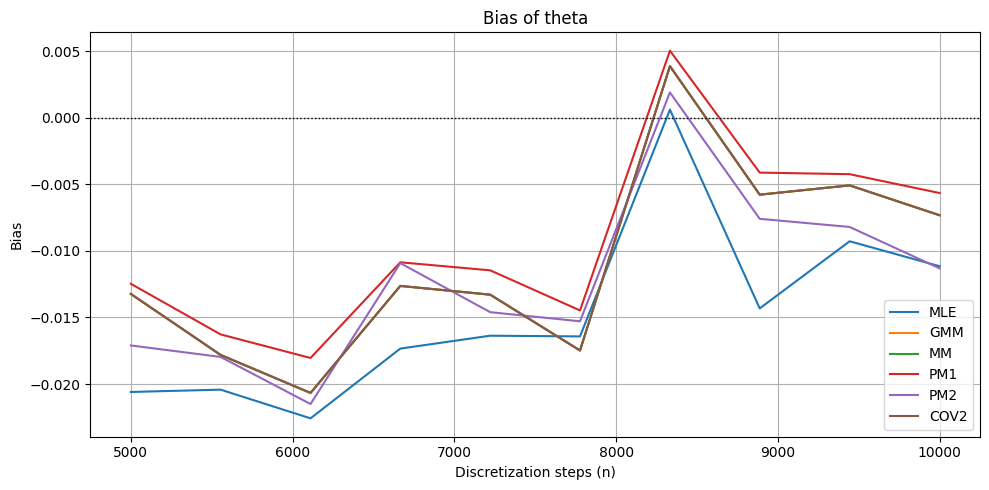

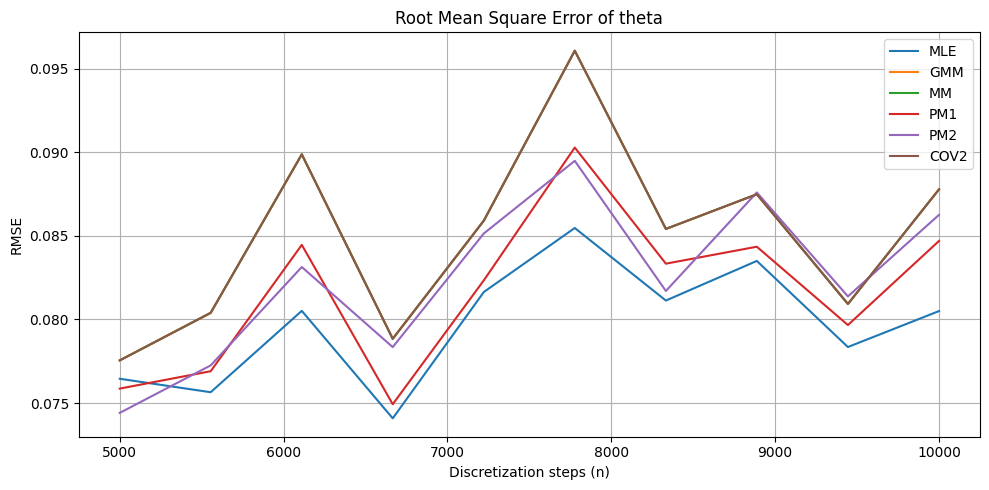

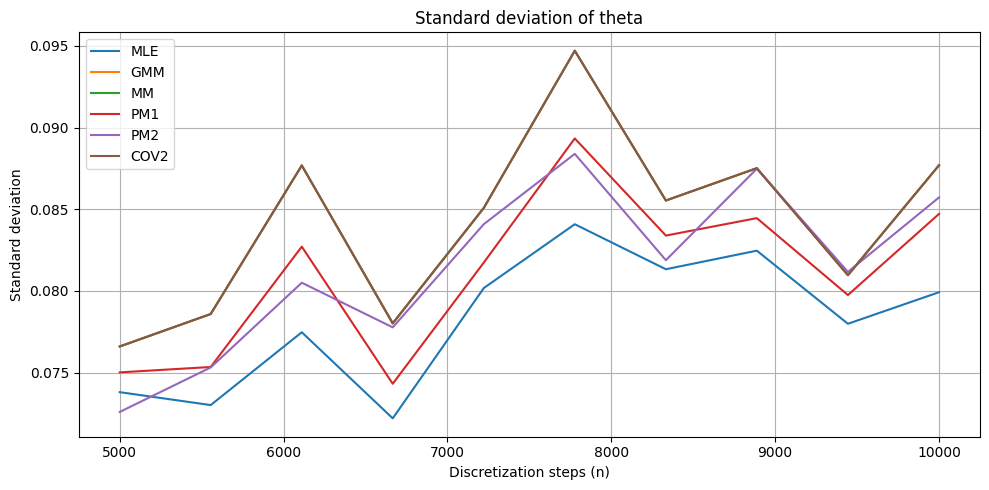

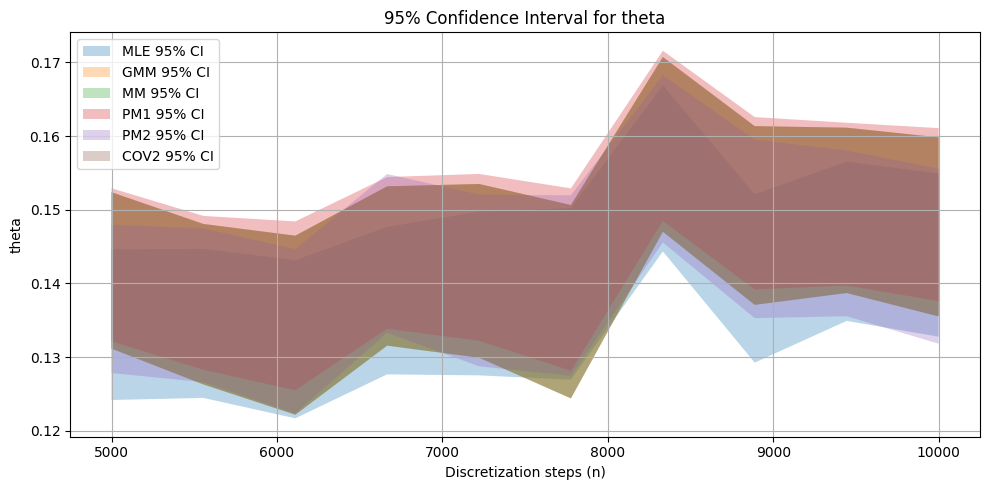

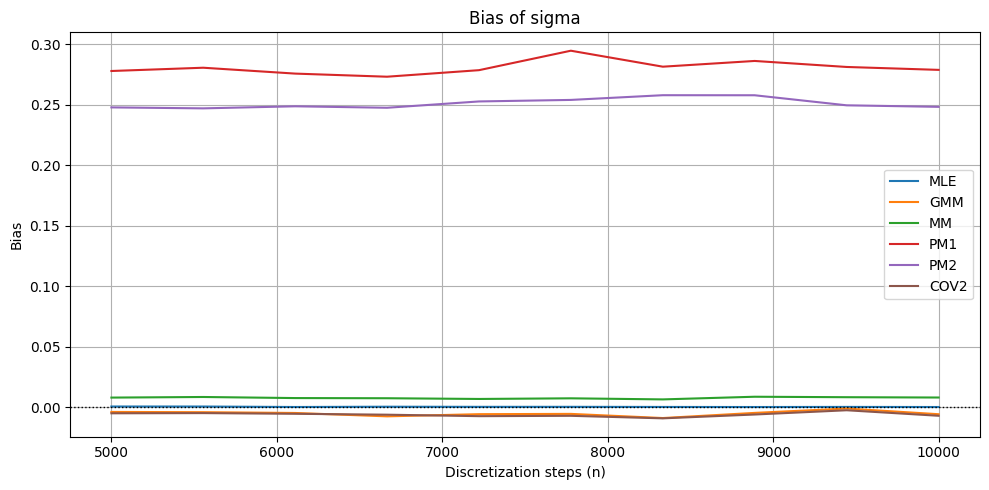

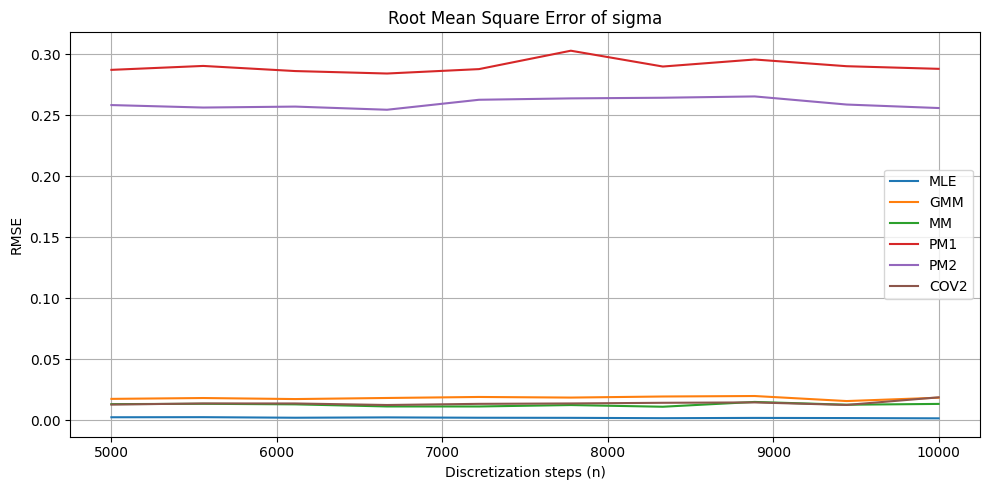

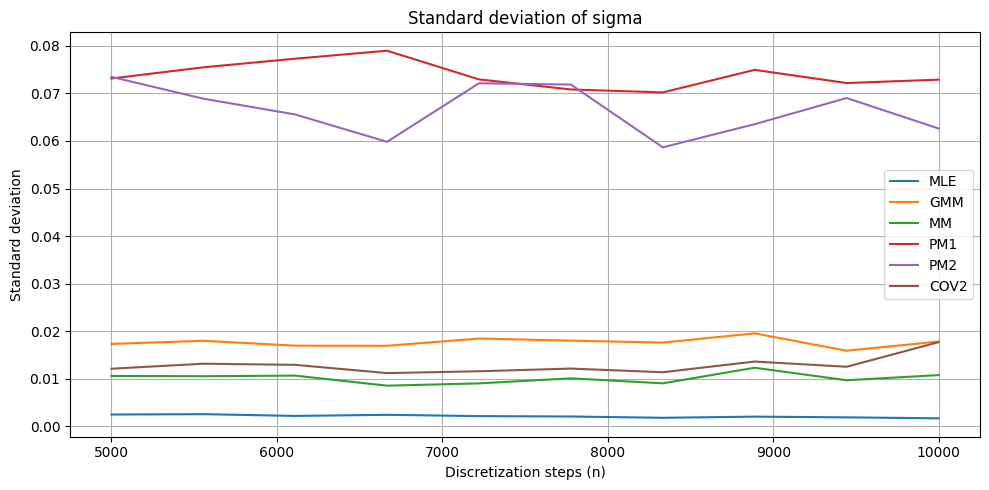

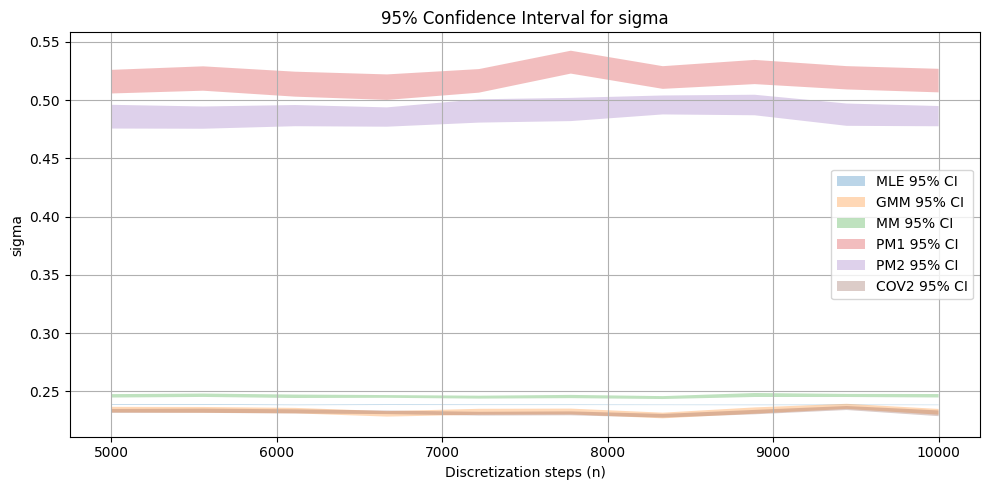

In [28]:
repeats = 200
def process_simulation(trajectory, n, T, kappa_true, theta_true, sigma_true, max_order, num_lags):
    theta_emp = np.mean(trajectory)
    lags = np.array([i * T / n for i in range(num_lags)])

    # MLE
    kappa_MLE, theta_MLE, sigma_MLE = estimate_parameters_mle(trajectory, T)

    # GMM
    kappa_GMM, sigma_GMM = estimate_kappa_sigma(trajectory, n, T, theta_emp, lags)

    # MM
    theta_MM, sigma2_MM, kappa_MM = moment_estimators(trajectory, T)
    sigma_MM = np.sqrt(sigma2_MM)

    # PM1
    theta_PM1, sigma2_PM1, kappa_PM1, _ = pure_moments_calibration(trajectory, max_order)
    sigma_PM1 = np.sqrt(sigma2_PM1)

    # PM2
    theta_PM2, sigma2_PM2, kappa_PM2, _ = pure_moments_calibration_2step(trajectory, max_order)
    sigma_PM2 = np.sqrt(sigma2_PM2)

    # COV2
    kappa_COV2, sigma_COV2 = covariance_2step(trajectory, n, T, theta_emp, lags)

    return {
        "MLE": (kappa_MLE, theta_MLE, sigma_MLE),
        "GMM": (kappa_GMM, theta_emp, sigma_GMM),
        "MM": (kappa_MM, theta_MM, sigma_MM),
        "PM1": (kappa_PM1, theta_PM1, sigma_PM1),
        "PM2": (kappa_PM2, theta_PM2, sigma_PM2),
        "COV2": (kappa_COV2, theta_emp, sigma_COV2),
    }
methods = ["MLE", "GMM", "MM", "PM1", "PM2", "COV2"]
params = ["kappa", "theta", "sigma"]

estimates = {m: {p: [] for p in params} for m in methods}
true_vals = {"kappa": kappa_true, "theta": theta_true, "sigma": sigma_true}
T = 20
n = 252*20
all_estimates_raw = {m: {p: [] for p in params} for m in methods}

for n in n_range:

    estimates_n = {m: {p: [] for p in params} for m in methods}


    for _ in range(repeats):
        vasicek_process = Vasicek(kappa_true, theta_true, sigma_true)
        trajectory = vasicek_process.generate(X0, T, 1, n)[0]

        results = process_simulation(trajectory, n, T, kappa_true, theta_true, sigma_true, max_order, num_lags)

        for m in methods:
            kappa, theta, sigma = results[m]
            estimates_n[m]["kappa"].append(kappa)
            estimates_n[m]["theta"].append(theta)
            estimates_n[m]["sigma"].append(sigma)
            all_estimates_raw[m]["kappa"].append(kappa)
            all_estimates_raw[m]["theta"].append(theta)
            all_estimates_raw[m]["sigma"].append(sigma)

    # Store aggregated stats
    for m in methods:
        for p in params:
            vals = np.array(estimates_n[m][p])
            mean = vals.mean()
            std = vals.std(ddof=1)
            bias = mean - true_vals[p]
            rmse = np.sqrt(np.mean((vals - true_vals[p])**2))

            ci_lo = mean - 1.96 * std / np.sqrt(repeats)
            ci_hi = mean + 1.96 * std / np.sqrt(repeats)

            estimates[m][p].append((bias, std, ci_lo, ci_hi,rmse))
print(len(params))
for p in params:
    # --- BIAIS ---
    plt.figure(figsize=(10, 5))
    for m in methods:
        bias_vals = [x[0] for x in estimates[m][p]]
        plt.plot(n_range, bias_vals, label=m)
        
    plt.axhline(0, color='black', linestyle=':', linewidth=1)
    plt.xlabel("Discretization steps (n)")
    plt.ylabel("Bias")
    plt.title(f"Bias of {p}")
    plt.grid(True)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    ## RMSE
    plt.figure(figsize=(10, 5))
    for m in methods:
        rmse_vals = [x[4] for x in estimates[m][p]]  # 5th element is RMSE
        plt.plot(n_range, rmse_vals, label=m)
    plt.xlabel("Discretization steps (n)")
    plt.ylabel("RMSE")
    plt.title(f"Root Mean Square Error of {p}")
    plt.grid(True)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    # --- ECART-TYPE ---
    plt.figure(figsize=(10, 5))
    for m in methods:
        std_vals = [x[1] for x in estimates[m][p]]
        plt.plot(n_range, std_vals, label=m)
    plt.xlabel("Discretization steps (n)")
    plt.ylabel("Standard deviation")
    plt.title(f"Standard deviation of {p}")
    plt.grid(True)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    # --- INTERVALLES DE CONFIANCE ---
    plt.figure(figsize=(10, 5))
    for m in methods:
        ci_lows  = [x[2] for x in estimates[m][p]]
        ci_highs = [x[3] for x in estimates[m][p]]
        plt.fill_between(n_range, ci_lows, ci_highs, alpha=0.3, label=f"{m} 95% CI")
    plt.xlabel("Discretization steps (n)")
    plt.ylabel(p)
    plt.title(f"95% Confidence Interval for {p}")
    plt.grid(True)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()



/tmp/ipykernel_603738/1025019884.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=methods, showfliers=False)


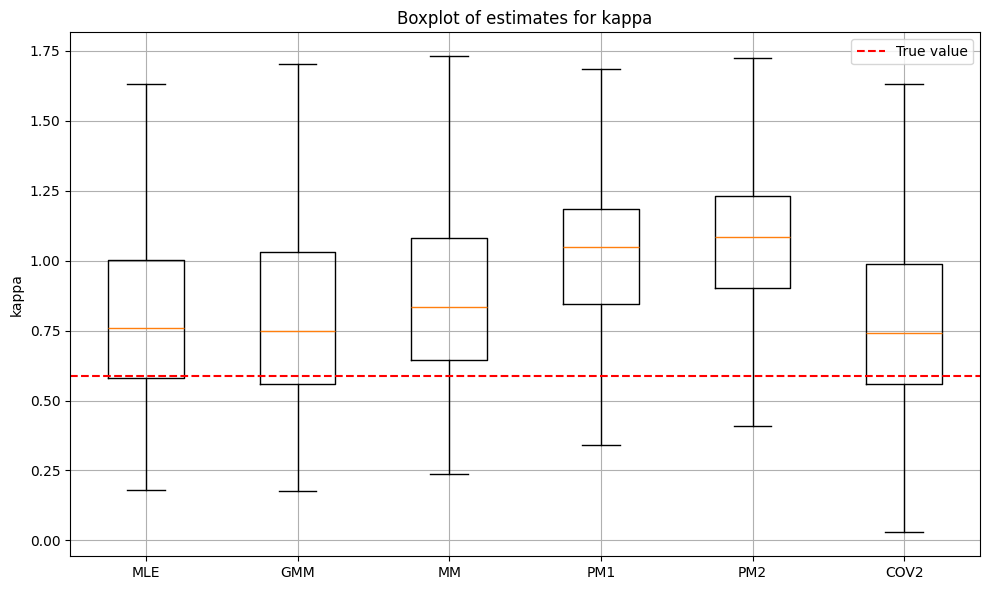

/tmp/ipykernel_603738/1025019884.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=methods, showfliers=False)


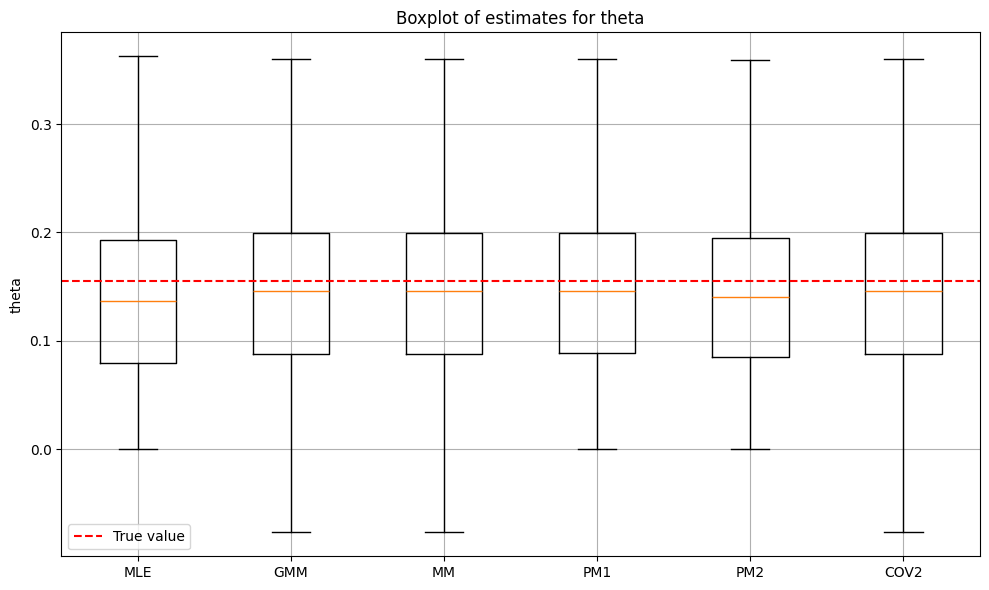

/tmp/ipykernel_603738/1025019884.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=methods, showfliers=False)


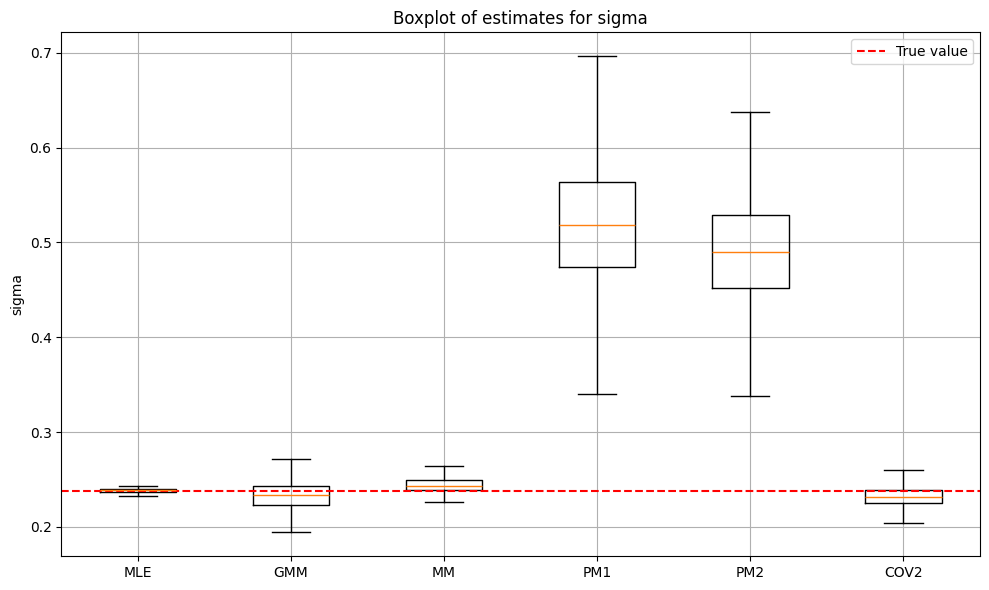

In [29]:
for p in params:
    plt.figure(figsize=(10, 6))
    
    # Prepare data
    data = [all_estimates_raw[m][p] for m in methods]

    # Boxplot
    plt.boxplot(data, labels=methods, showfliers=False)
    
    # Add true value line
    plt.axhline(y=true_vals[p], color='red', linestyle='--', linewidth=1.5, label='True value')

    plt.title(f"Boxplot of estimates for {p}")
    plt.ylabel(p)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()